### Purpose of Notebook: build model to predict whether or not a premier league match will have a score greater than 2 (or 2.5 as the bettings firms classify the cutoff point)

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson,skellam
from pandas.plotting import scatter_matrix
import datetime
from functools import reduce
#from astropy.stats import boostrap
%matplotlib inline
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_info_columns', 150)
pd.set_option('display.max_info_rows', 150)
plt.style.use('seaborn')

In [8]:
# pull data and explore
df = pd.read_csv("season-1819.csv")
df2 = pd.read_csv("season-1718.csv")

# create total score field, which will need for binary label
df['total_score'] = (df.FTHG + df.FTAG)
df2['total_score'] = (df2.FTHG + df2.FTAG)

# get overview of dataframes
print('18-19 df info and head:\n')
df.info()
df.head()
df.describe()

print('\n18-19 df info and head:\n')
df2.info()
df2.head()
df2.describe()

18-19 df info and head:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 23 columns):
Date           object
HomeTeam       object
AwayTeam       object
FTHG           int64
FTAG           int64
FTR            object
HTHG           int64
HTAG           int64
HTR            object
Referee        object
HS             int64
AS             int64
HST            int64
AST            int64
HF             int64
AF             int64
HC             int64
AC             int64
HY             int64
AY             int64
HR             int64
AR             int64
total_score    int64
dtypes: int64(17), object(6)
memory usage: 52.0+ KB


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score
0,2018-08-10,Man United,Leicester,2,1,H,1,0,H,A Marriner,8,13,6,4,11,8,2,5,2,1,0,0,3
1,2018-08-11,Bournemouth,Cardiff,2,0,H,1,0,H,K Friend,12,10,4,1,11,9,7,4,1,1,0,0,2
2,2018-08-11,Fulham,Crystal Palace,0,2,A,0,1,A,M Dean,15,10,6,9,9,11,5,5,1,2,0,0,2
3,2018-08-11,Huddersfield,Chelsea,0,3,A,0,2,A,C Kavanagh,6,13,1,4,9,8,2,5,2,1,0,0,3
4,2018-08-11,Newcastle,Tottenham,1,2,A,1,2,A,M Atkinson,15,15,2,5,11,12,3,5,2,2,0,0,3


,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score
count,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.00000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000
mean,1.564014,1.252595,0.698962,0.581315,14.076125,10.937716,4.820069,3.930796,10.494810,10.363322,5.67474,4.577855,1.550173,1.723183,0.051903,0.083045,2.816609
std,1.339913,1.164523,0.883510,0.782489,5.915588,4.305552,2.686543,2.245842,3.222233,3.571128,2.92346,2.738929,1.218381,1.213144,0.222216,0.276429,1.610814
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,3.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,2.000000,8.000000,8.000000,4.00000,3.000000,1.000000,1.000000,0.000000,0.000000,2.000000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,10.000000,5.000000,4.000000,10.000000,10.000000,5.00000,4.000000,1.000000,2.000000,0.000000,0.000000,3.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,14.000000,6.000000,5.000000,12.000000,13.000000,8.00000,6.000000,2.000000,2.000000,0.000000,0.000000,4.000000
max,6.000000,6.000000,4.000000,3.000000,36.000000,25.000000,14.000000,12.000000,23.000000,21.000000,14.00000,14.000000,6.000000,5.000000,1.000000,1.000000,8.000000



18-19 df info and head:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 23 columns):
Date           object
HomeTeam       object
AwayTeam       object
FTHG           int64
FTAG           int64
FTR            object
HTHG           int64
HTAG           int64
HTR            object
Referee        object
HS             int64
AS             int64
HST            int64
AST            int64
HF             int64
AF             int64
HC             int64
AC             int64
HY             int64
AY             int64
HR             int64
AR             int64
total_score    int64
dtypes: int64(17), object(6)
memory usage: 68.4+ KB


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score
0,2017-08-11,Arsenal,Leicester,4,3,H,2,2,D,M Dean,27,6,10,3,9,12,9,4,0,1,0,0,7
1,2017-08-12,Brighton,Man City,0,2,A,0,0,D,M Oliver,6,14,2,4,6,9,3,10,0,2,0,0,2
2,2017-08-12,Chelsea,Burnley,2,3,A,0,3,A,C Pawson,19,10,6,5,16,11,8,5,3,3,2,0,5
3,2017-08-12,Crystal Palace,Huddersfield,0,3,A,0,2,A,J Moss,14,8,4,6,7,19,12,9,1,3,0,0,3
4,2017-08-12,Everton,Stoke,1,0,H,1,0,H,N Swarbrick,9,9,4,1,13,10,6,7,1,1,0,0,1


,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,1.531579,1.147368,0.607895,0.515789,13.584211,10.855263,4.626316,3.763158,10.218421,10.478947,5.739474,4.544737,1.478947,1.565789,0.044737,0.057895,2.678947
std,1.340087,1.177793,0.793403,0.756511,5.771439,4.858700,2.706845,2.317015,3.256360,3.336388,2.993047,2.767241,1.256993,1.259639,0.219375,0.233852,1.665125
min,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,9.000000,7.000000,3.000000,2.000000,8.000000,8.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,10.500000,4.000000,3.500000,10.000000,10.000000,5.000000,4.000000,1.000000,1.000000,0.000000,0.000000,3.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,14.000000,6.000000,5.000000,12.000000,13.000000,8.000000,6.000000,2.000000,2.000000,0.000000,0.000000,4.000000
max,7.000000,6.000000,4.000000,3.000000,35.000000,30.000000,15.000000,14.000000,19.000000,26.000000,18.000000,13.000000,6.000000,7.000000,2.000000,1.000000,9.000000


### ^^ Great, we don't have to worry about missing data.

# first look at goal distribution

In [10]:
# creating hist plotting function, 
# overlay with poisson pmf, common distribution for sports goals
def hagoal_plot(df=df, title='#Goals/Match', 
                bin_field=['FTHG','FTAG'], 
                hist_label=['Home', 'Away'], 
                set_alpha=0.5,
                goal_max=10):
    """function to create the home/away goal histogram with poisson pmf overlay"""
    
    pos_pred = np.column_stack([[poisson.pmf(i, df[bin_field].mean()[j]) for i in range(goal_max)] 
                                    for j in range(len(bin_field))])

    # poisson pmf lines
    if len(bin_field) == 2:
        plt.hist(df[bin_field].values, range(10), 
                  alpha=set_alpha, label=hist_label,
                  density=True, color=['r', 'b'])
        _pois_1 = plt.plot([i-0.5 for i in range(1,goal_max+1)], pos_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = 'r')
        _pois2, = plt.plot([i-0.5 for i in range(1,goal_max+1)], pos_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = 'b')
    else:
        plt.hist(df[bin_field].values, range(10), 
                 alpha=set_alpha, label=hist_label,density=True, color=['r'])
        _pois_1 = plt.plot([i-0.5 for i in range(1,goal_max+1)], pos_pred[:,0],
                  linestyle='-', marker='o',label="Total Score", color = 'r')

    plt.xticks([i-0.5 for i in range(1,goal_max+1)],[i for i in range(10)])
    leg=plt.legend(loc='upper right', fontsize=15, ncol=2)
    leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})
    plt.xlabel("#Goals/Match",size=13)
    plt.ylabel("% of Matches",size=13)
    plt.title(title, size=14, fontweight='bold')
    plt.ylim([-0.004, 0.4])
    plt.tight_layout()
    plt.show() 

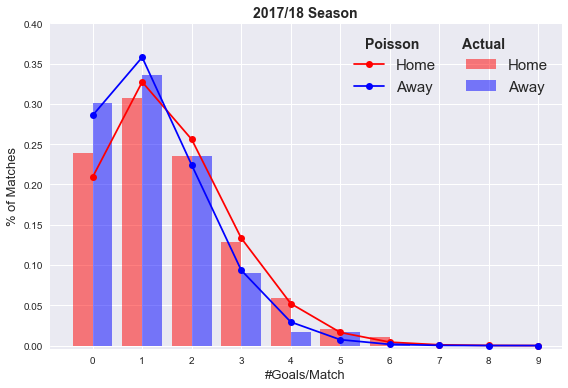

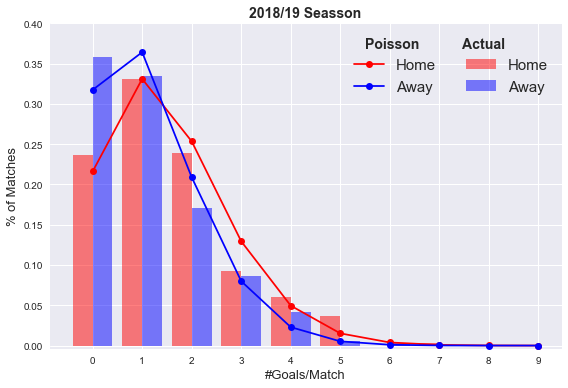

In [11]:
# run goal plotting function on 2017/18 and 2017/18 seasons and combined
hagoal_plot(df=df, title='2017/18 Season')
hagoal_plot(df=df2, title='2018/19 Seasson')

### ^^^ Looks like home/away goals hist follow quite closely to their relative poisson pmfs

In [12]:
# create total score field, which will be label/y value of model
df_total = pd.concat([df, df2], ignore_index=True)
print('18-19 df info and head:\n')
df_total.info()
df_total.head()

18-19 df info and head:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 23 columns):
Date           object
HomeTeam       object
AwayTeam       object
FTHG           int64
FTAG           int64
FTR            object
HTHG           int64
HTAG           int64
HTR            object
Referee        object
HS             int64
AS             int64
HST            int64
AST            int64
HF             int64
AF             int64
HC             int64
AC             int64
HY             int64
AY             int64
HR             int64
AR             int64
total_score    int64
dtypes: int64(17), object(6)
memory usage: 120.3+ KB


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score
0,2018-08-10,Man United,Leicester,2,1,H,1,0,H,A Marriner,8,13,6,4,11,8,2,5,2,1,0,0,3
1,2018-08-11,Bournemouth,Cardiff,2,0,H,1,0,H,K Friend,12,10,4,1,11,9,7,4,1,1,0,0,2
2,2018-08-11,Fulham,Crystal Palace,0,2,A,0,1,A,M Dean,15,10,6,9,9,11,5,5,1,2,0,0,2
3,2018-08-11,Huddersfield,Chelsea,0,3,A,0,2,A,C Kavanagh,6,13,1,4,9,8,2,5,2,1,0,0,3
4,2018-08-11,Newcastle,Tottenham,1,2,A,1,2,A,M Atkinson,15,15,2,5,11,12,3,5,2,2,0,0,3


In [13]:
# now lets look at the mean of the home/away goals
df[['FTHG','FTAG']].mean()
df2[['FTHG','FTAG']].mean()
df_total[['FTHG','FTAG']].mean()

# now look at variance
np.var(df[['FTHG','FTAG']])
np.var(df2[['FTHG','FTAG']])
np.var(df_total[['FTHG','FTAG']])

# for reference in poisson distribution the
# expected value = variance

FTHG    1.564014
FTAG    1.252595
dtype: float64

FTHG    1.531579
FTAG    1.147368
dtype: float64

FTHG    1.545590
FTAG    1.192825
dtype: float64

FTHG    1.789155
FTAG    1.351421
dtype: float64

FTHG    1.791108
FTAG    1.383546
dtype: float64

FTHG    1.790522
FTAG    1.372385
dtype: float64

#### ^^ the variance looks pretty close to its mean counterpart so it appears that this is from a poisson distibution. 

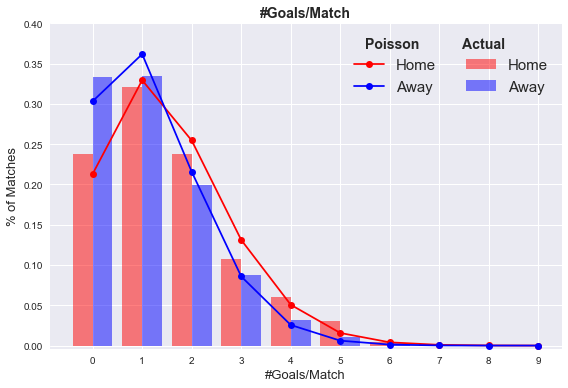

In [14]:
hagoal_plot(df=df_total)

### ^^^ both seasons combined also follows closely to the poisson

## Now lets do the same plotting exercise but for total goals 

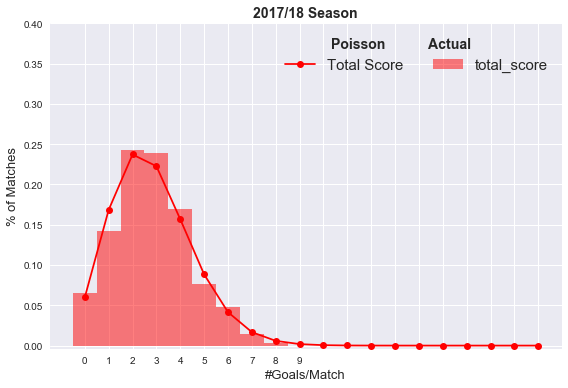

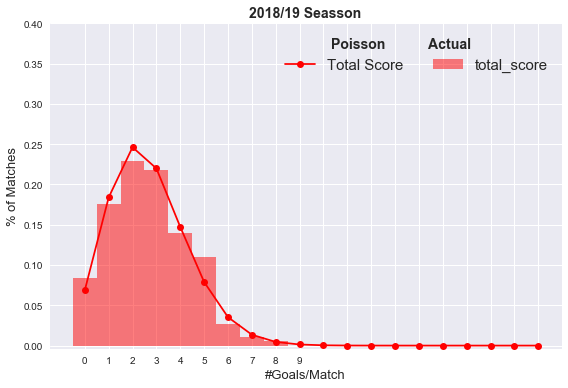

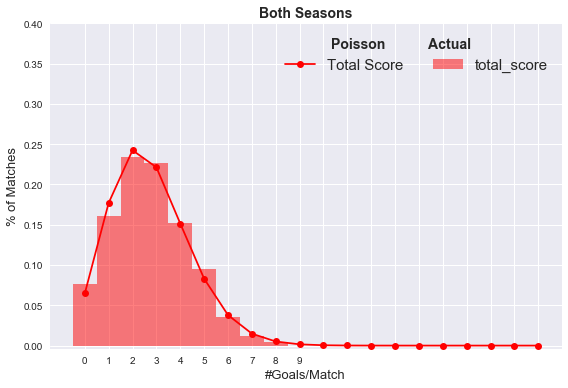

In [15]:
hagoal_plot(df=df, title='2017/18 Season', 
            bin_field=['total_score'], 
            hist_label=['total_score'],
            goal_max = 20)
hagoal_plot(df=df2, title='2018/19 Seasson',
            bin_field=['total_score'],
            hist_label=['total_score'],
            goal_max = 20)
hagoal_plot(df=df_total, title='Both Seasons', 
            bin_field=['total_score'],
            hist_label=['total_score'],
            goal_max = 20)

In [16]:
df['total_score'].mean()
df2['total_score'].mean()
df_total['total_score'].mean()

2.8166089965397925

2.6789473684210527

2.7384155455904335

In [17]:
# now lets look at the mean of the home/away goals
df['total_score'].mean()
df2['total_score'].mean()
df_total['total_score'].mean()

# now look at variance
np.var(df['total_score'])
np.var(df2['total_score'])
np.var(df_total['total_score'])

# for reference in poisson distribution the
# expected value = variance

2.8166089965397925

2.6789473684210527

2.7384155455904335

2.585744902479616

2.7653462603878114

2.69241064346536

#### ^^ the variance for total score also looks pretty close to its mean counterpart so it appears that this is from a poisson distibution. 

### now lets set up our binary y variable for classification/binary regression prep

### we are going to use the combined data of 2017 through the current 2018/19 season and use days/months from match date to current date as a field in our future classifier

In [18]:
# lets create some more variables; mostly totals of the home and away features 
df_total['y'] = df_total['total_score'].apply(lambda x: 1 if x > 2.5 else 0)
df_total['total_half_score'] = df_total.HTHG + df_total.HTAG
df_total['TS'] = df_total.HS + df_total.AS # TS = total shots
df_total['TST'] = df_total.HST + df_total.AST # TST = total shots on target
df_total['corners'] = df_total.HC + df_total.AC
df_total['yellows'] = df_total.HY + df_total.AY
df_total['reds'] = df_total.HR + df_total.AR
df_total['fouls'] = df_total.HF + df_total.AF

# remove FTR and HTR since we can get result info from scores
df_total = df_total.drop(columns=['FTR', 'HTR'])

df_total.info()
df_total.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 29 columns):
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
y                   int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
dtypes: int64(25), object(4)
memory usage: 151.6+ KB


,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score,y,total_half_score,TS,TST,corners,yellows,reds,fouls
0,2018-08-10,Man United,Leicester,2,1,1,0,A Marriner,8,13,6,4,11,8,2,5,2,1,0,0,3,1,1,21,10,7,3,0,19
1,2018-08-11,Bournemouth,Cardiff,2,0,1,0,K Friend,12,10,4,1,11,9,7,4,1,1,0,0,2,0,1,22,5,11,2,0,20
2,2018-08-11,Fulham,Crystal Palace,0,2,0,1,M Dean,15,10,6,9,9,11,5,5,1,2,0,0,2,0,1,25,15,10,3,0,20
3,2018-08-11,Huddersfield,Chelsea,0,3,0,2,C Kavanagh,6,13,1,4,9,8,2,5,2,1,0,0,3,1,2,19,5,7,3,0,17
4,2018-08-11,Newcastle,Tottenham,1,2,1,2,M Atkinson,15,15,2,5,11,12,3,5,2,2,0,0,3,1,3,30,7,8,4,0,23
5,2018-08-11,Watford,Brighton,2,0,1,0,J Moss,19,6,5,0,10,16,8,2,2,2,0,0,2,0,1,25,5,10,4,0,26
6,2018-08-11,Wolves,Everton,2,2,1,1,C Pawson,11,6,4,5,8,7,3,6,0,1,0,1,4,1,2,17,9,9,1,1,15
7,2018-08-12,Arsenal,Man City,0,2,0,1,M Oliver,9,17,3,8,11,14,2,9,2,2,0,0,2,0,1,26,11,11,4,0,25
8,2018-08-12,Liverpool,West Ham,4,0,2,0,A Taylor,18,5,8,2,14,9,5,4,1,2,0,0,4,1,2,23,10,9,3,0,23
9,2018-08-12,Southampton,Burnley,0,0,0,0,G Scott,18,16,3,6,10,9,8,5,0,1,0,0,0,0,0,34,9,13,1,0,19


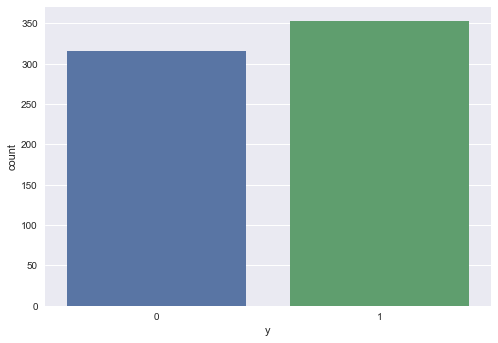

In [19]:
sns.countplot(x='y', data=df_total)
plt.show()

<Figure size 1800x720 with 0 Axes>

total score swarmplot by HomeTeam


<Figure size 1800x720 with 0 Axes>

total score swarmplot by AwayTeam


<Figure size 1800x720 with 0 Axes>

total score swarmplot by Referee


<Figure size 1800x720 with 0 Axes>

total score swarmplot by total_half_score


<Figure size 1800x720 with 0 Axes>

total score swarmplot by TS


<Figure size 1800x720 with 0 Axes>

total score swarmplot by TST


<Figure size 1800x720 with 0 Axes>

total score swarmplot by corners


<Figure size 1800x720 with 0 Axes>

total score swarmplot by yellows


<Figure size 1800x720 with 0 Axes>

total score swarmplot by reds


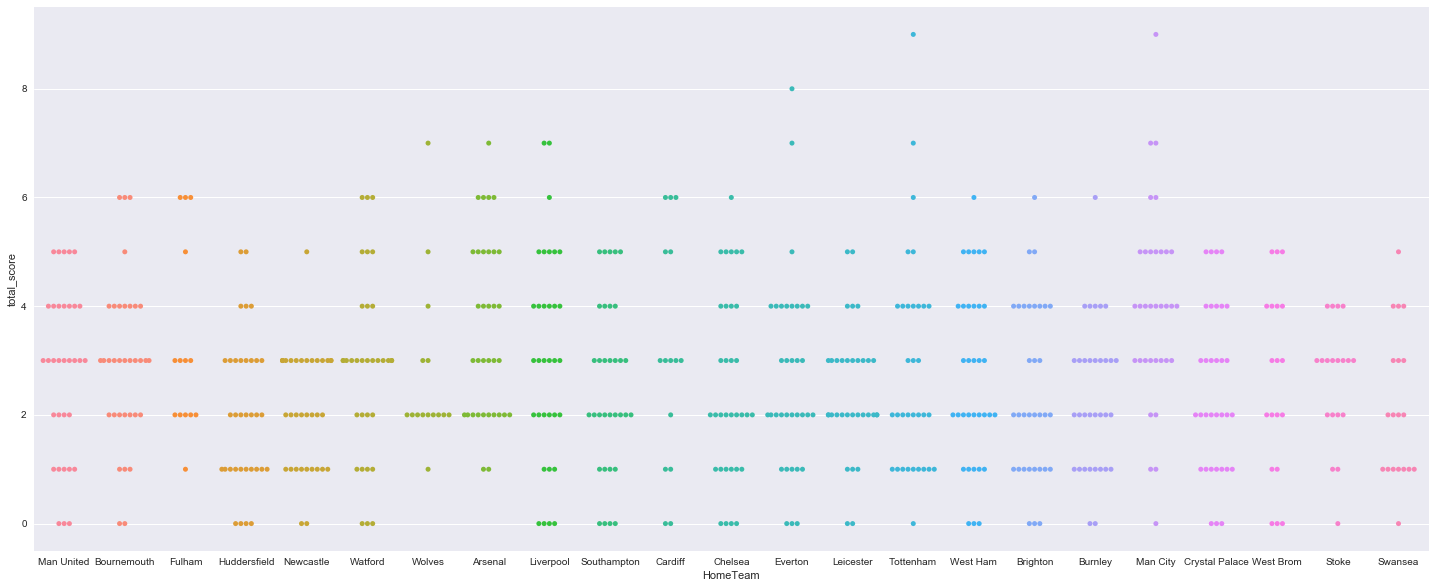

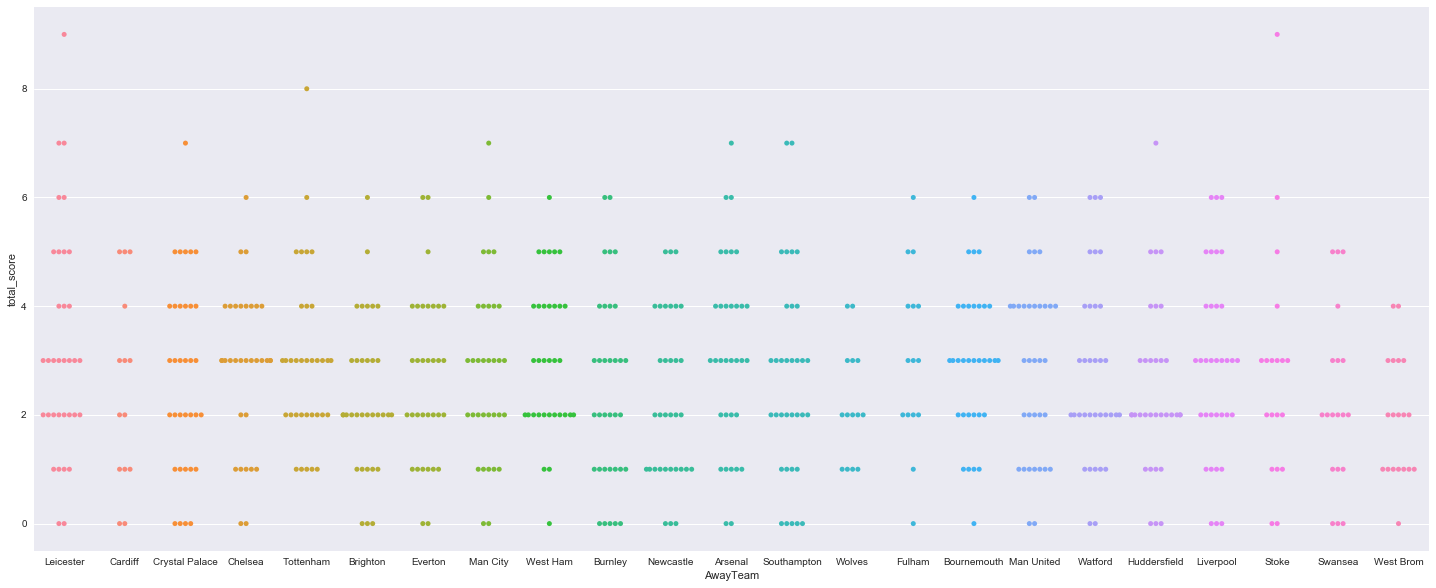

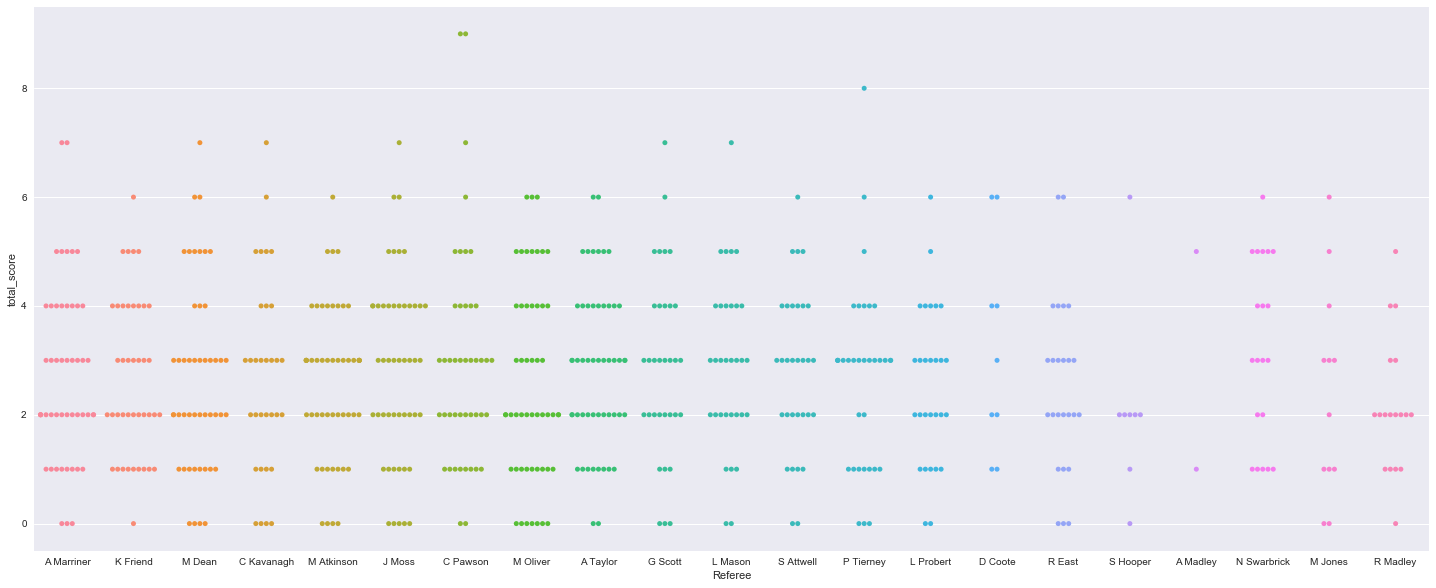

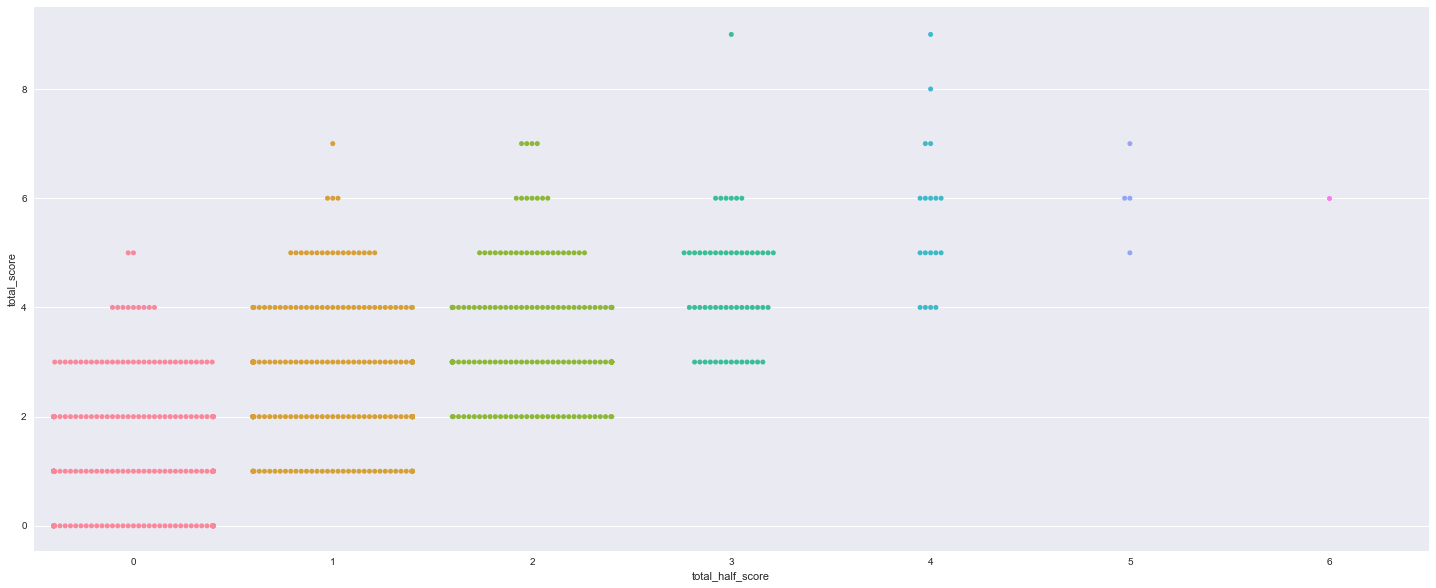

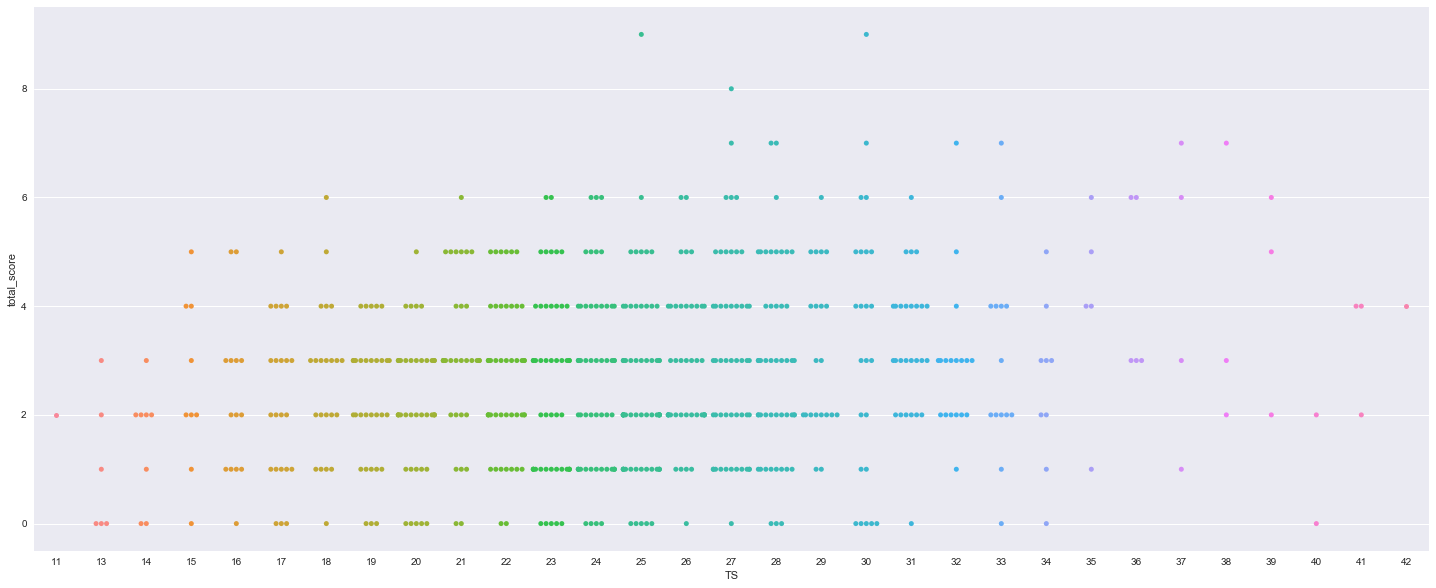

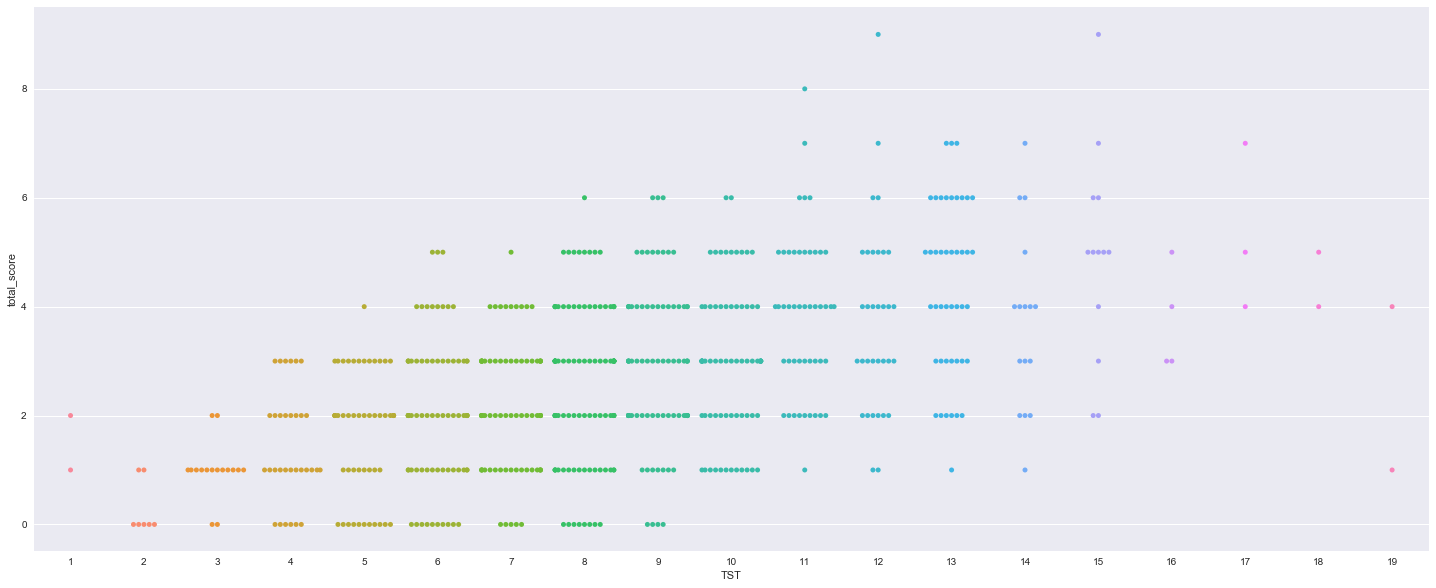

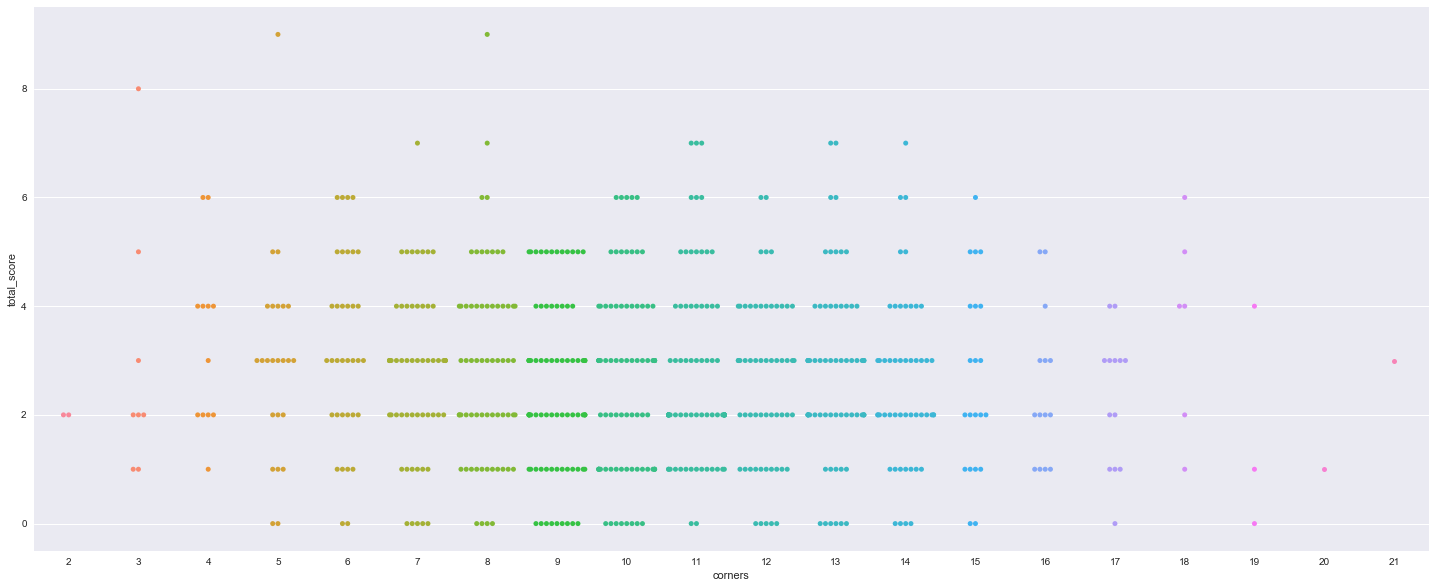

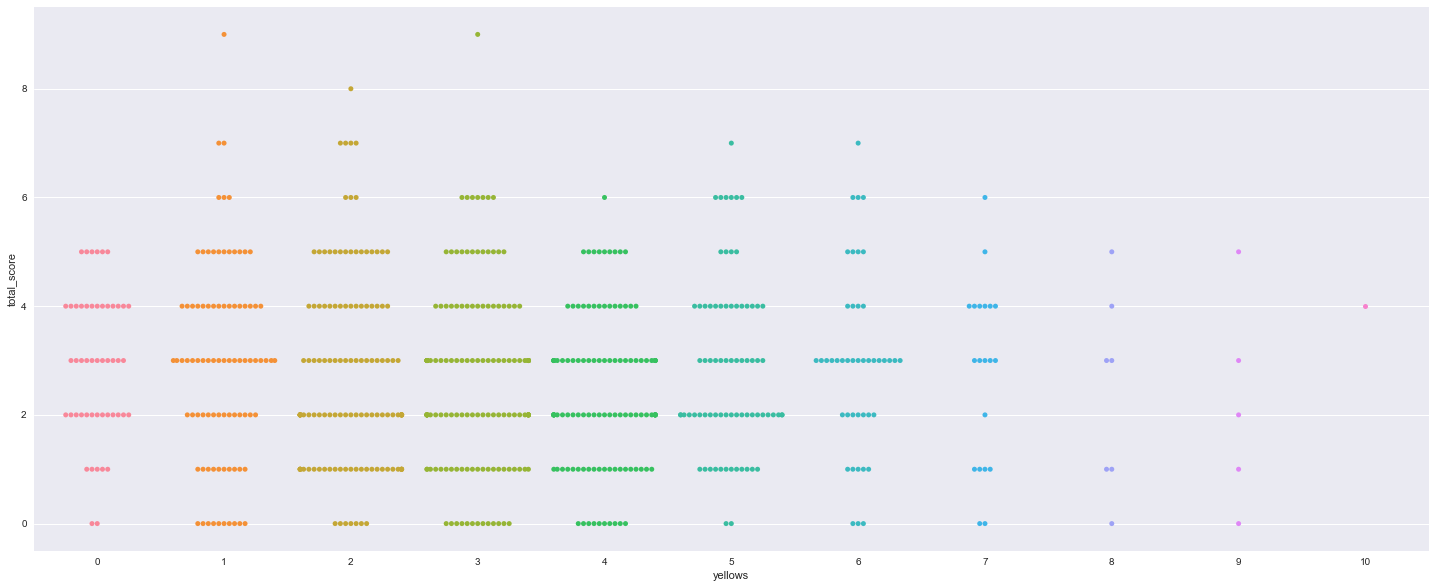

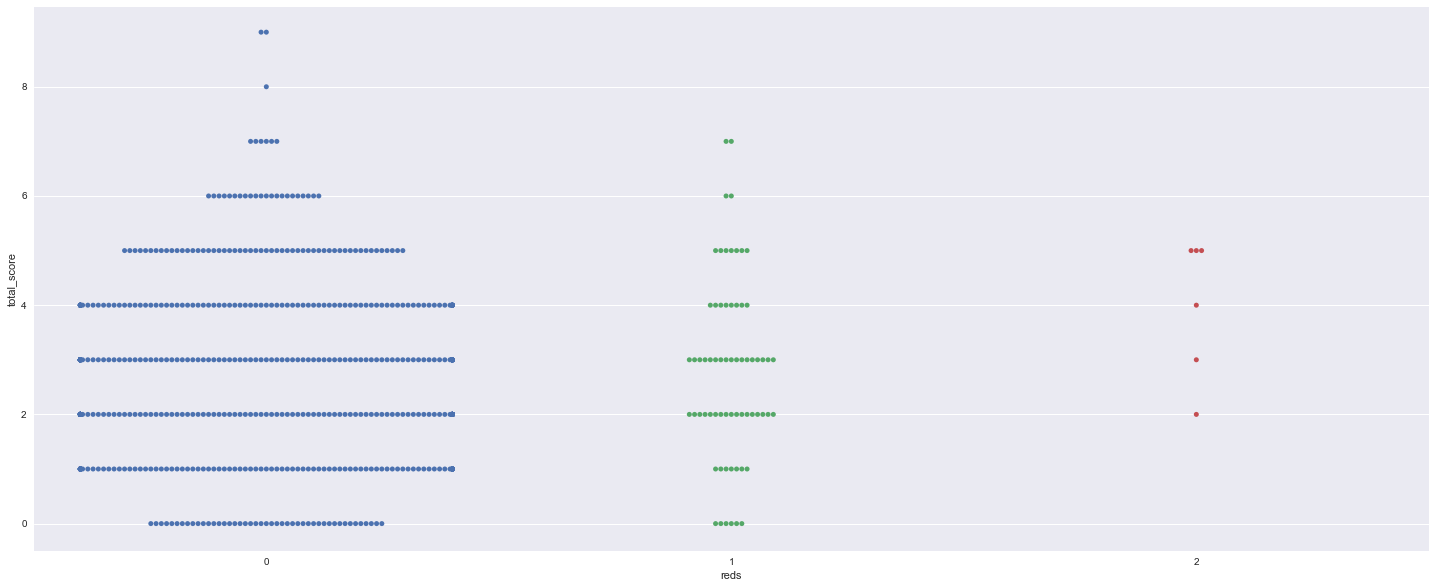

In [20]:
# now lets look at total score swarm plots by various features
swarm_list = ['HomeTeam', 'AwayTeam', 'Referee','total_half_score', 
              'TS', 'TST', 'corners', 'yellows', 'reds']

for x in swarm_list:
    plt.figure(figsize=(25,10))
    print('total score swarmplot by ' + x)
    sns.swarmplot(df_total[x], df_total.total_score)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

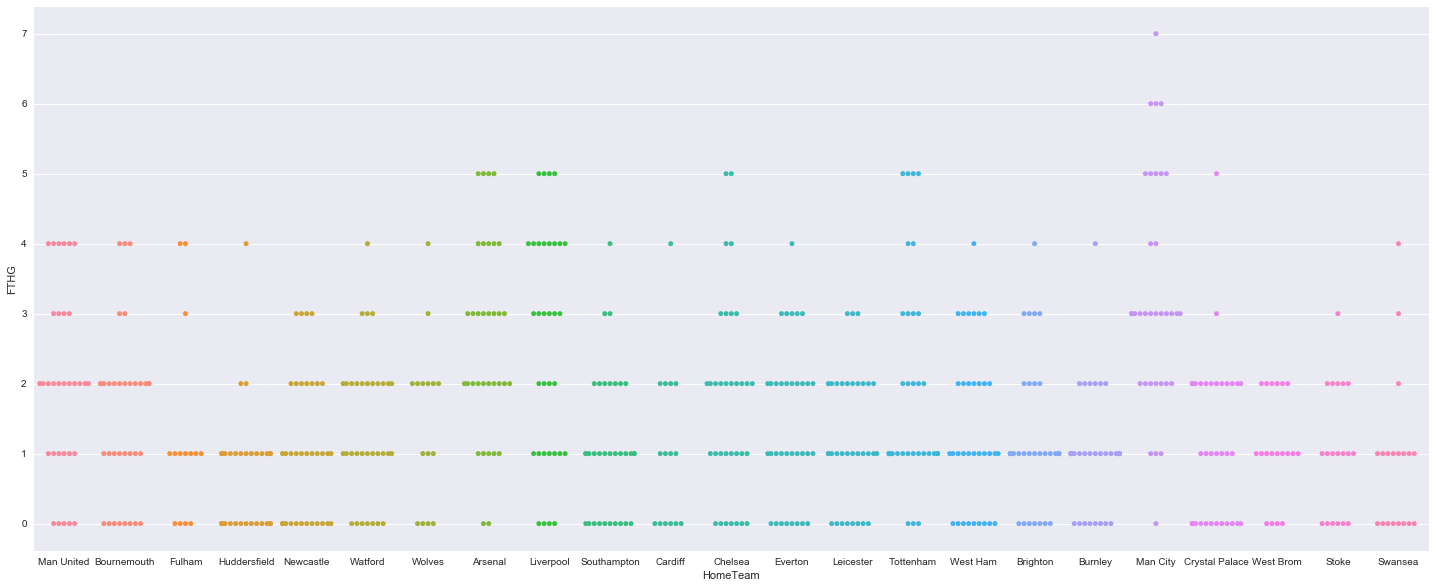

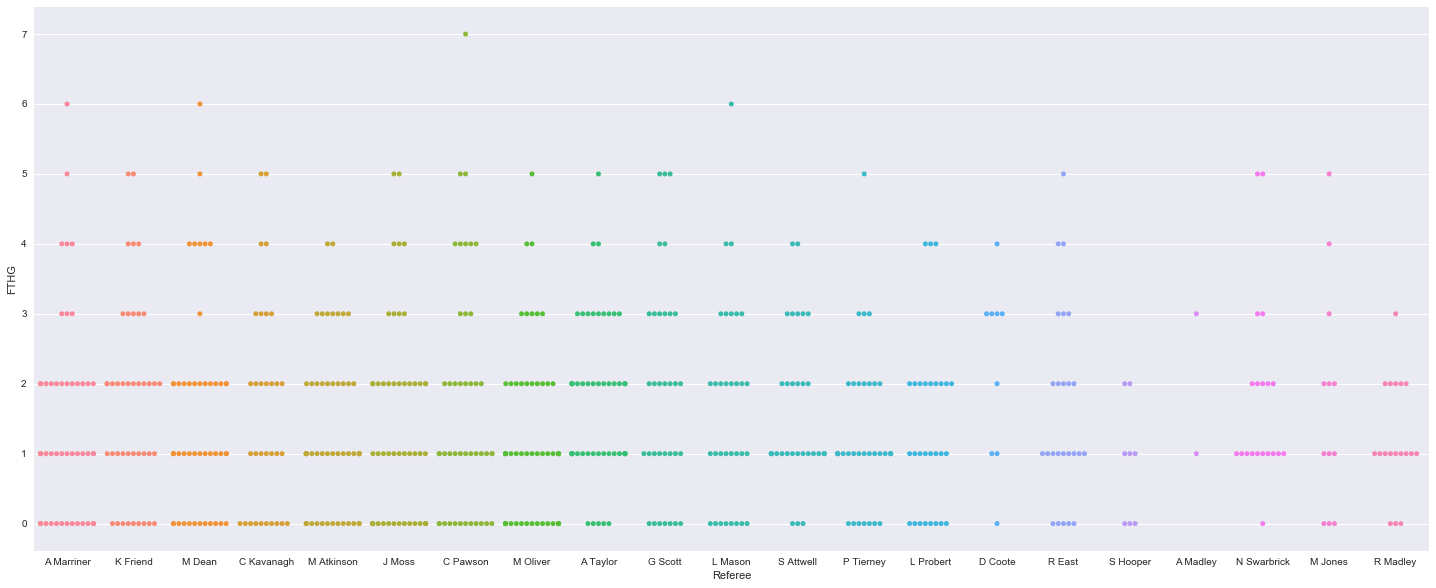

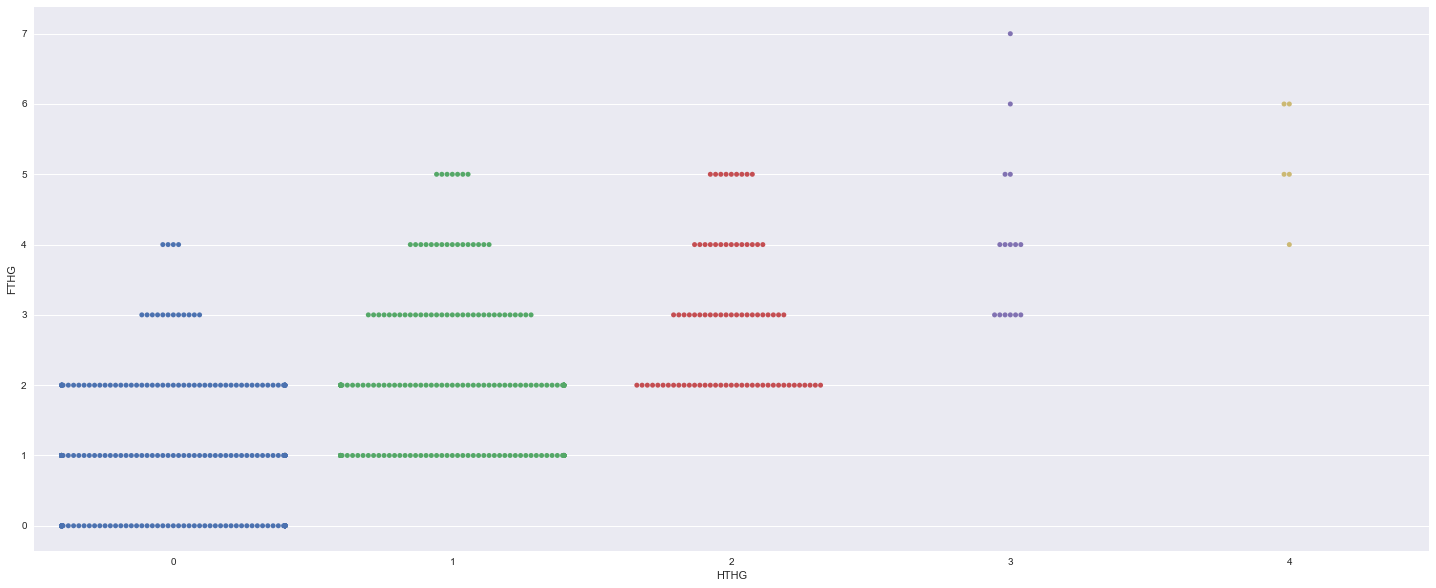

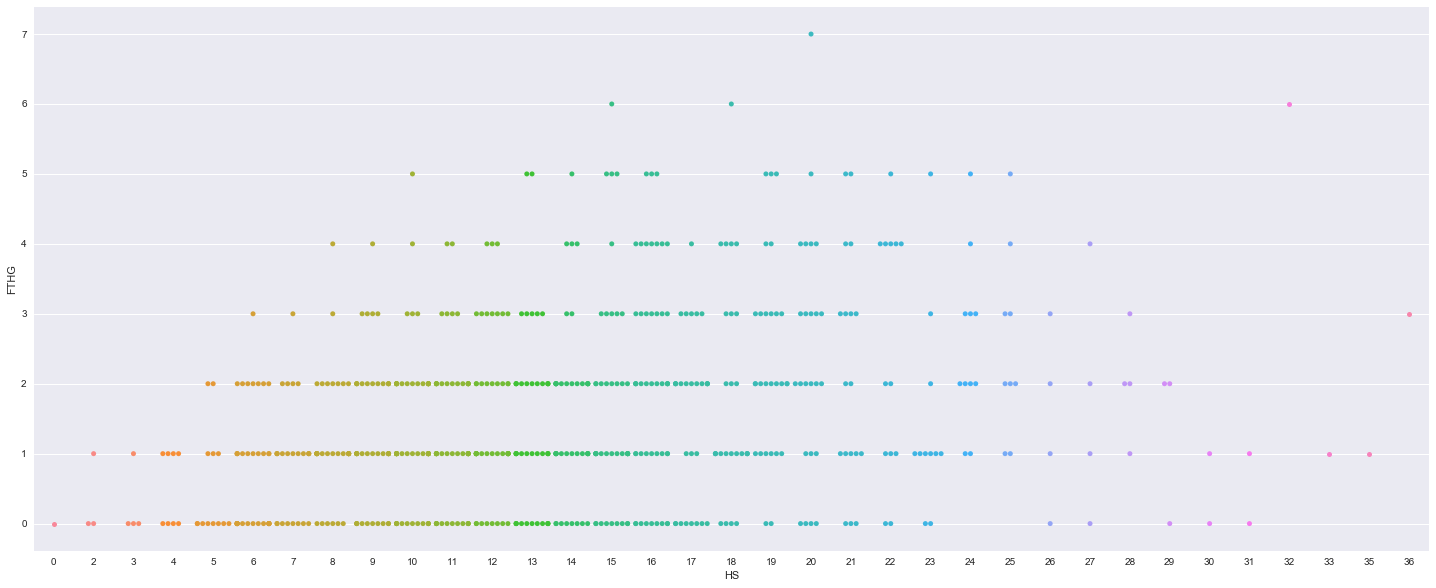

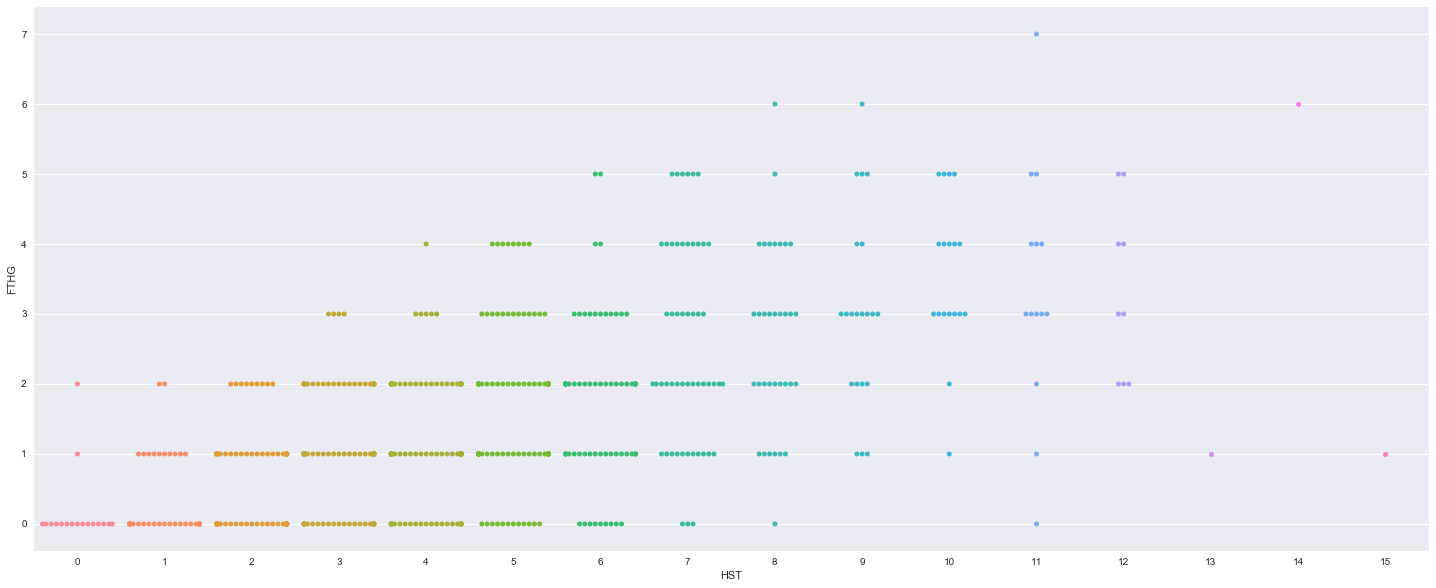

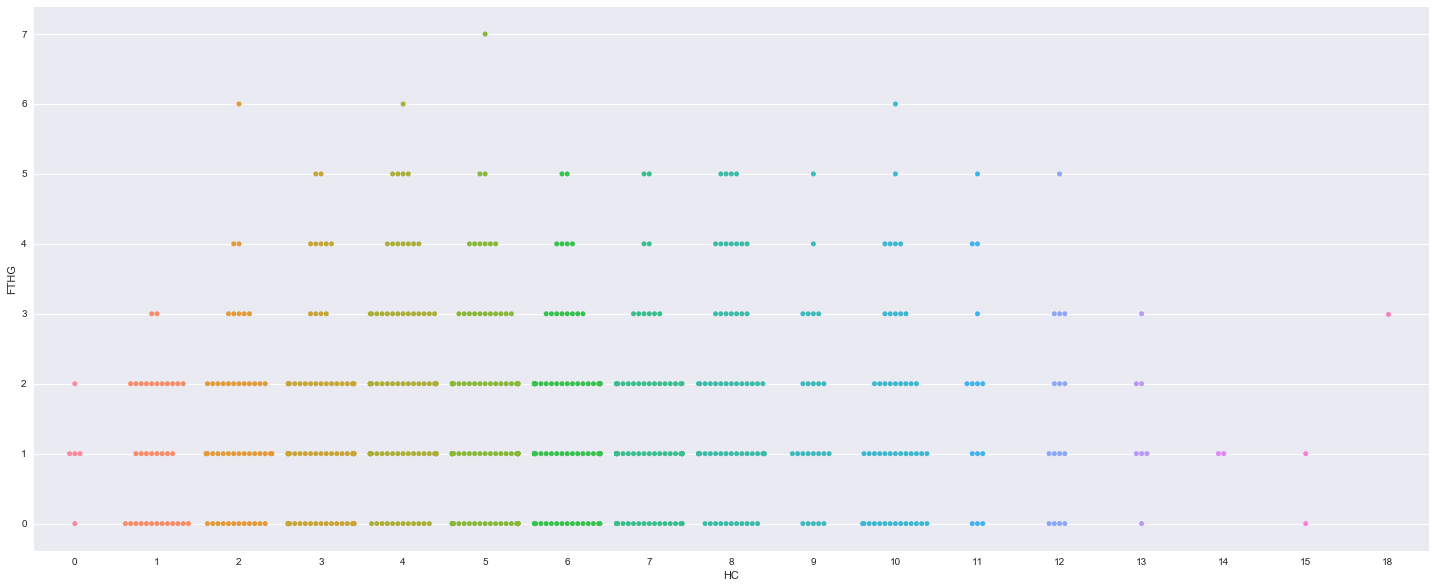

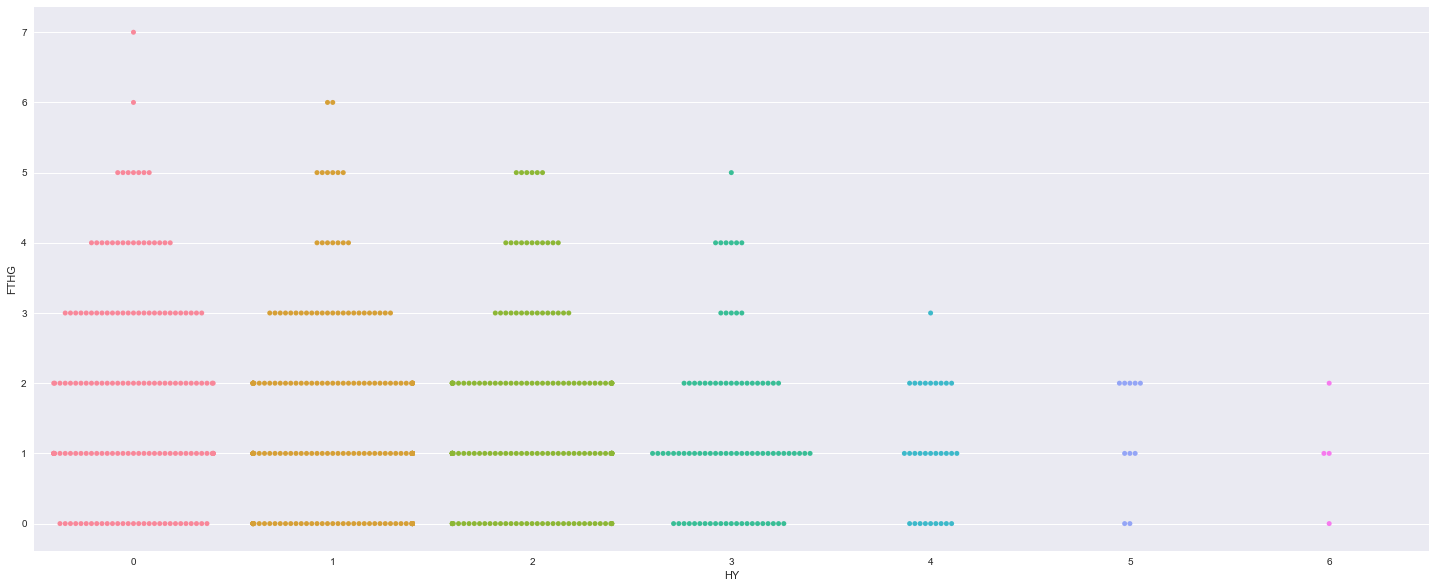

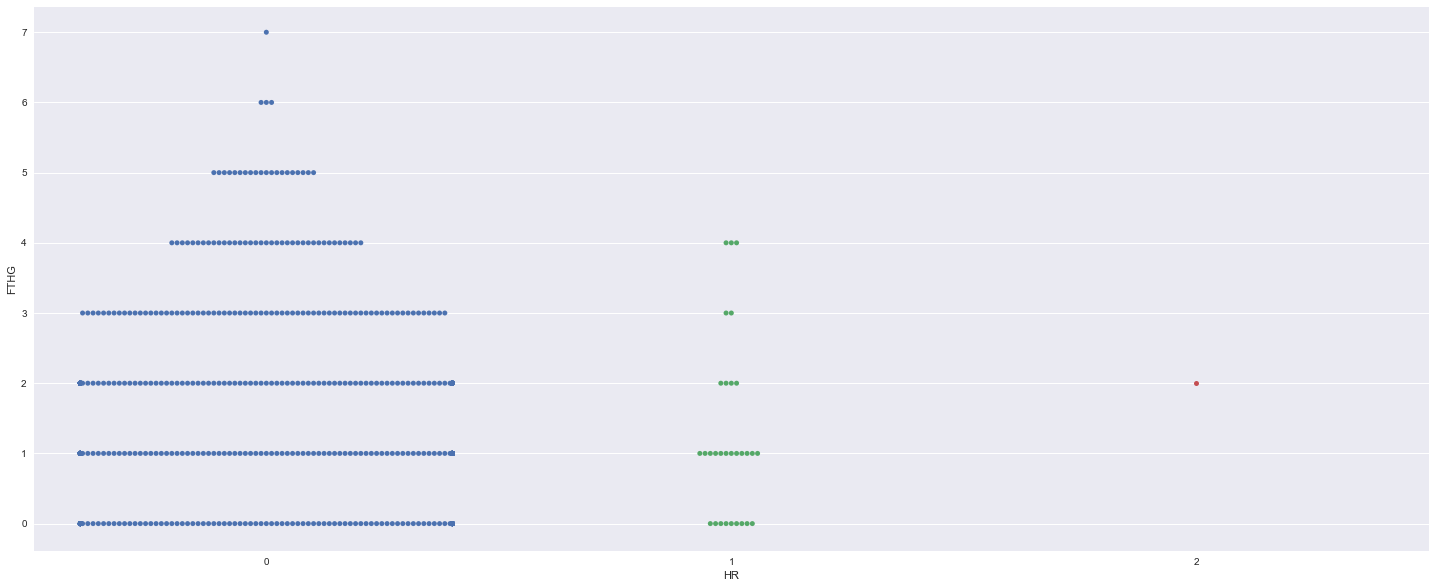

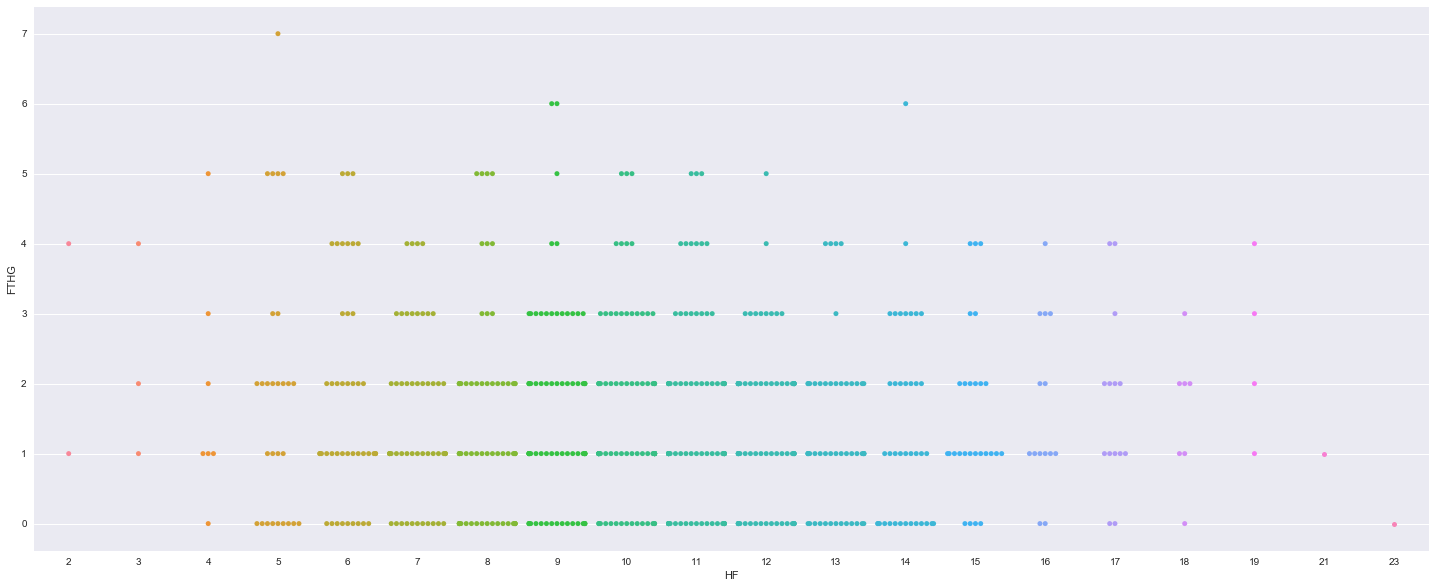

In [21]:
# now lets look at home score swarm plots by home features
total_list = ['HomeTeam', 'Referee','HTHG', 'HS', 
              'HST', 'HC', 'HY', 'HR', 'HF']

for x in total_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.FTHG)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

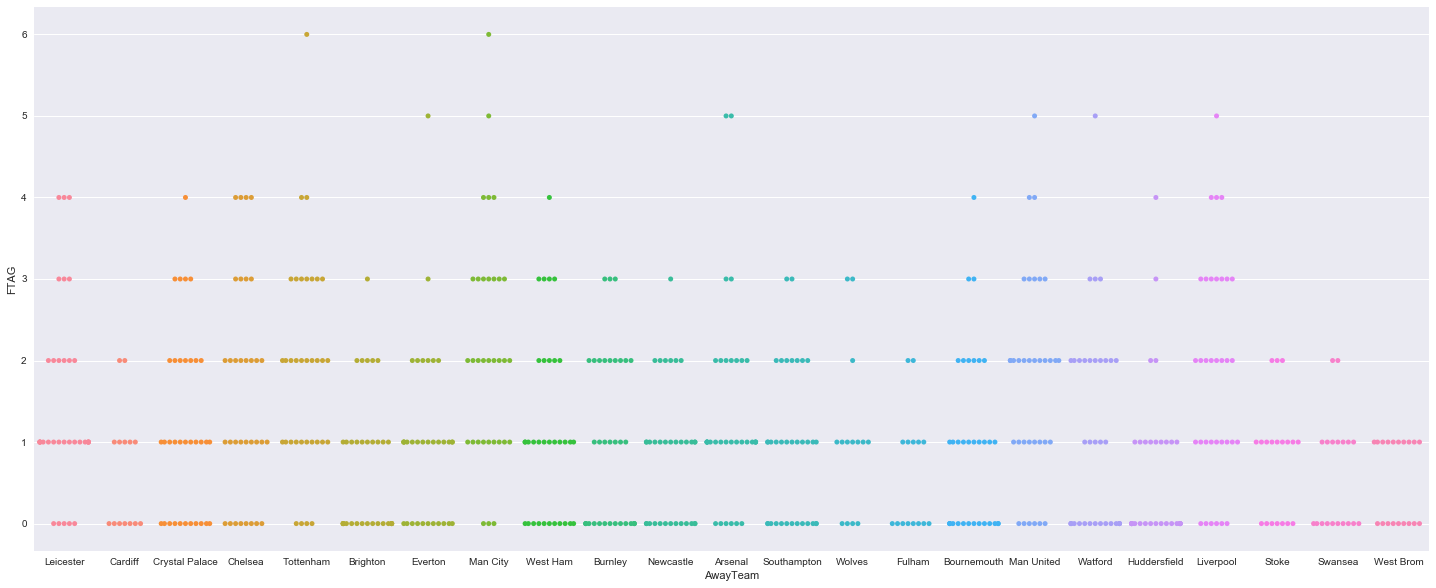

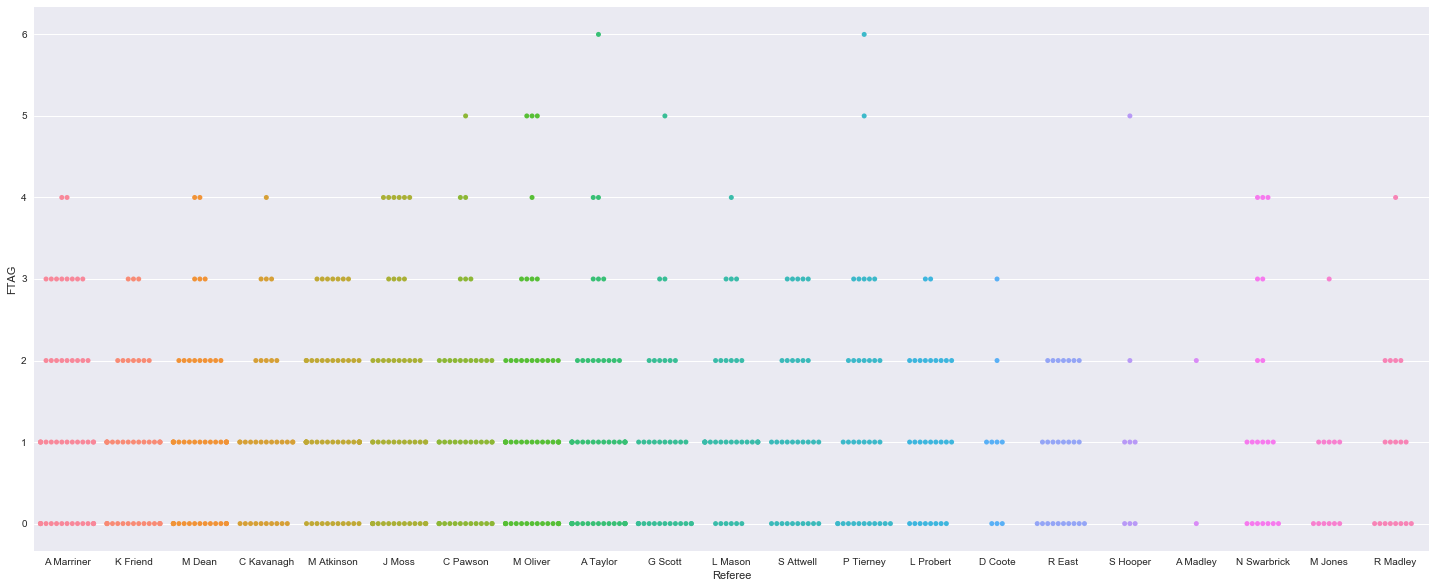

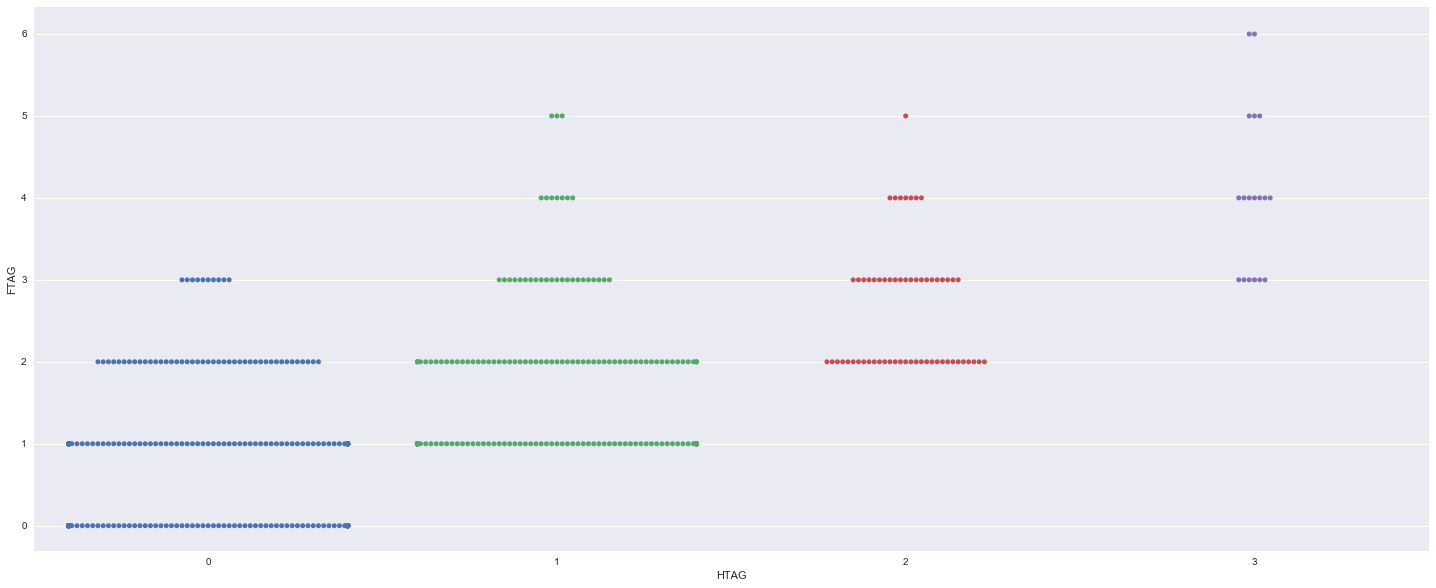

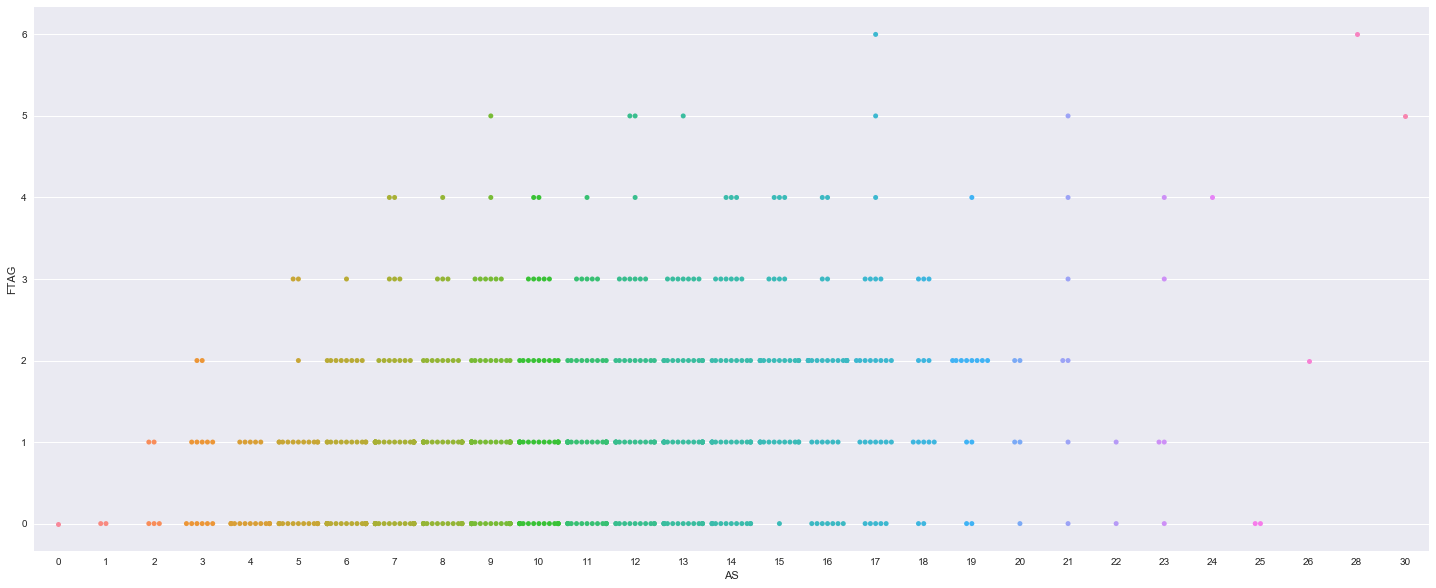

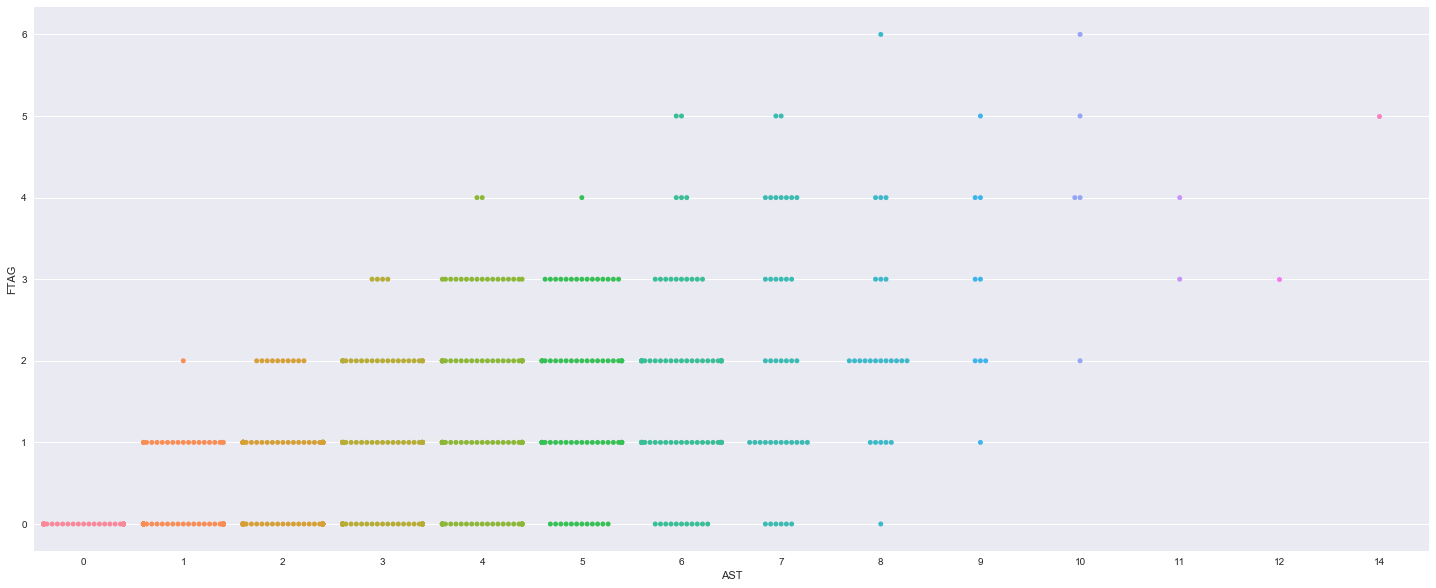

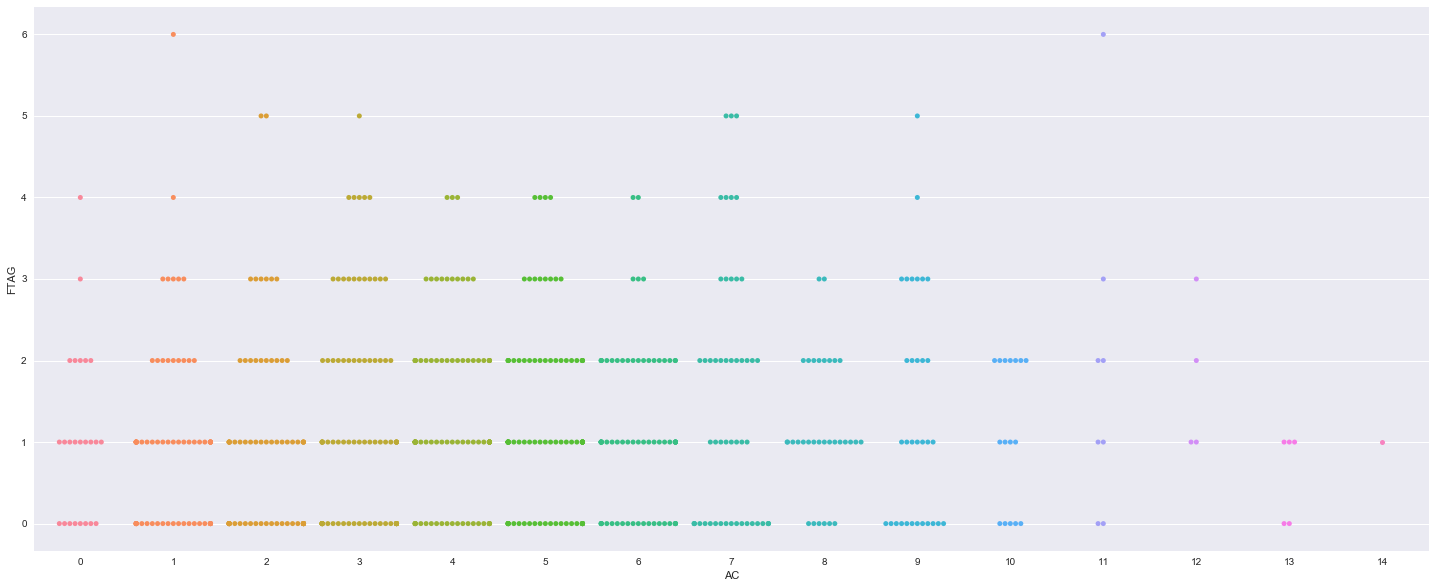

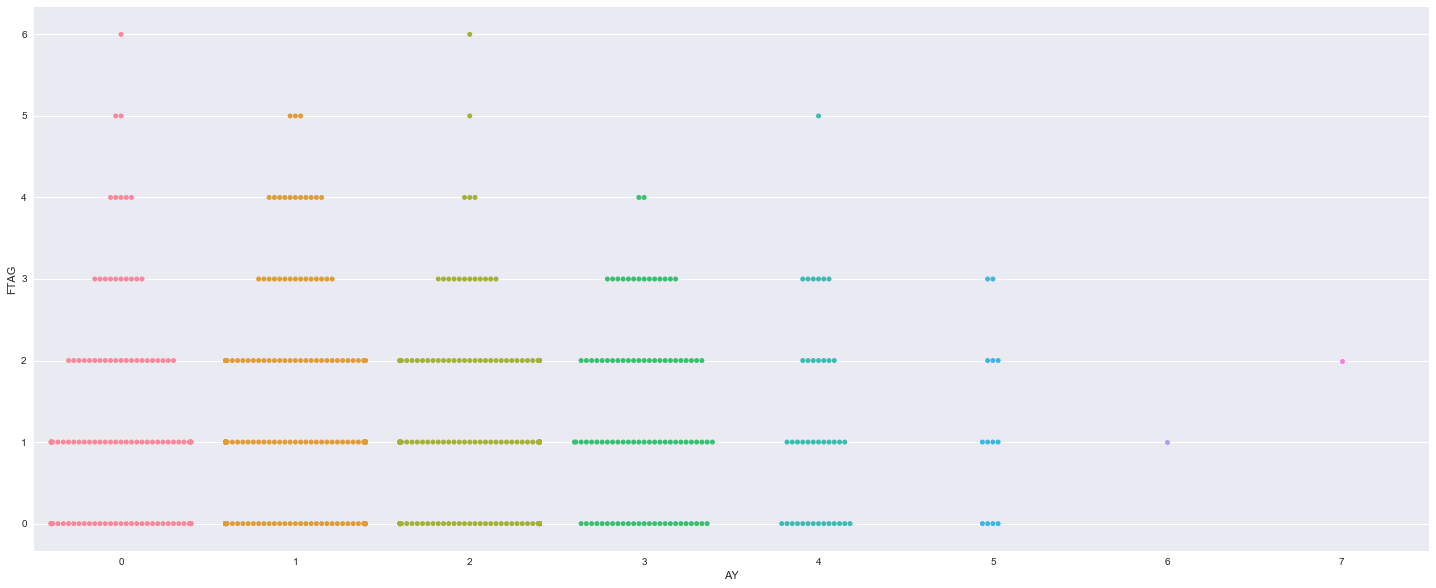

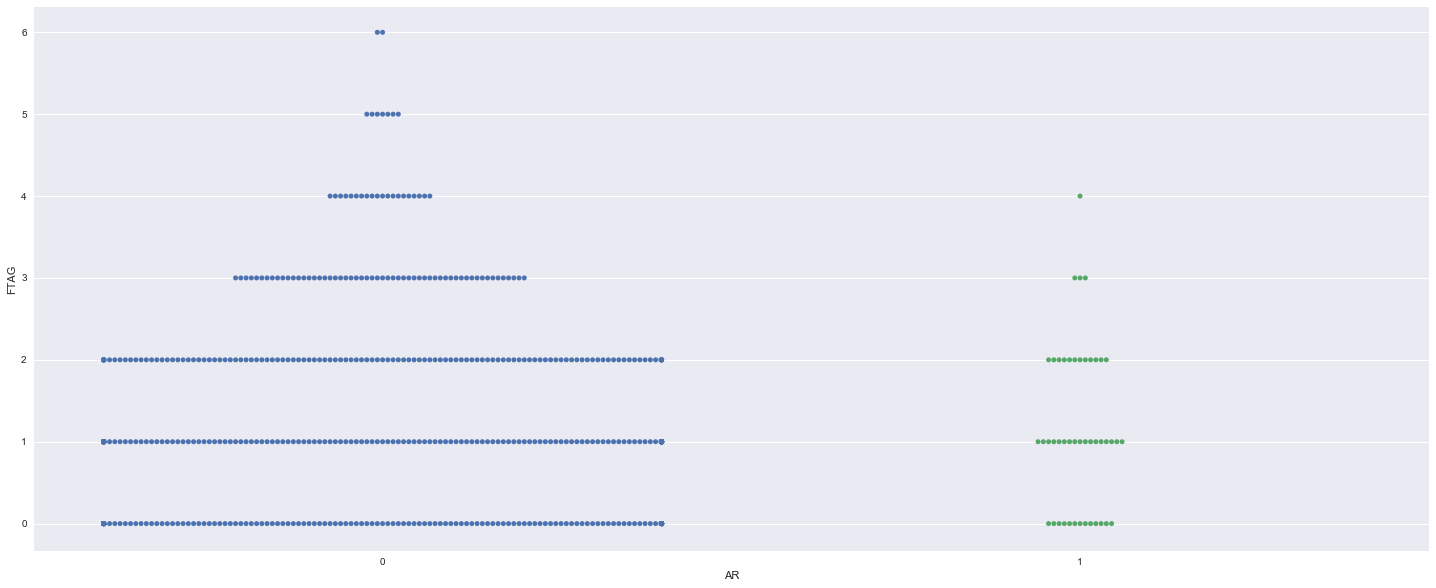

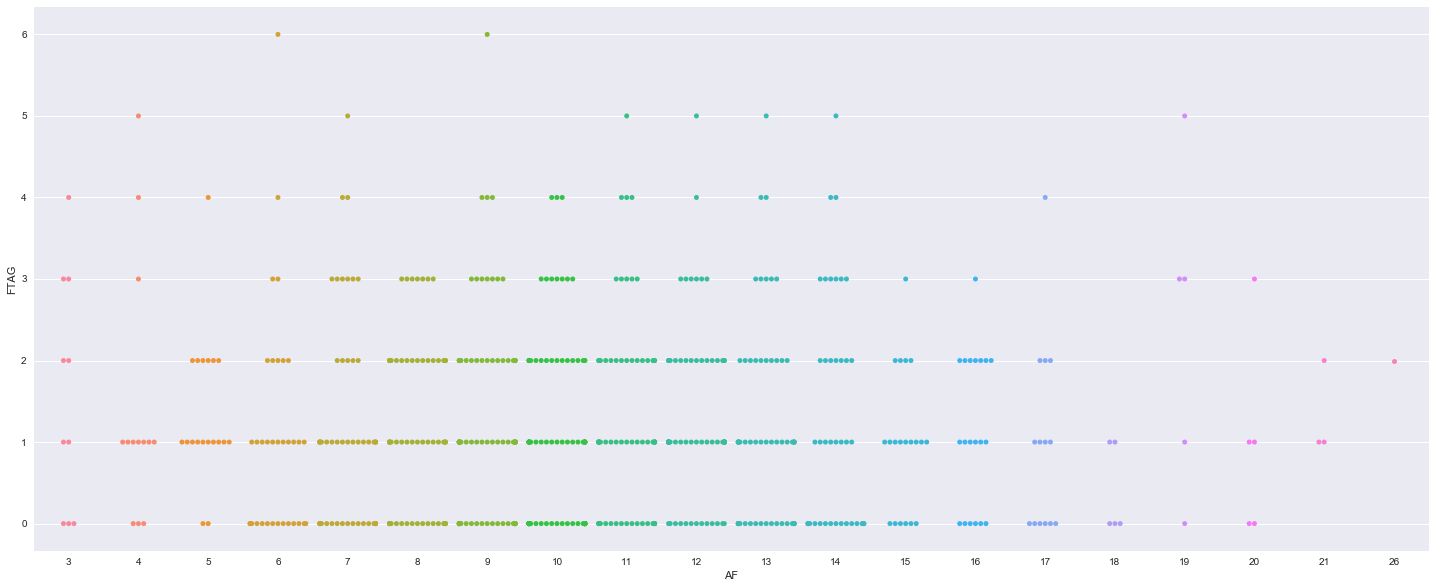

In [22]:
# now lets look at away score swarm plots by away features
away_list = ['AwayTeam', 'Referee','HTAG', 'AS', 
              'AST', 'AC', 'AY', 'AR', 'AF']

for x in away_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.FTAG)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

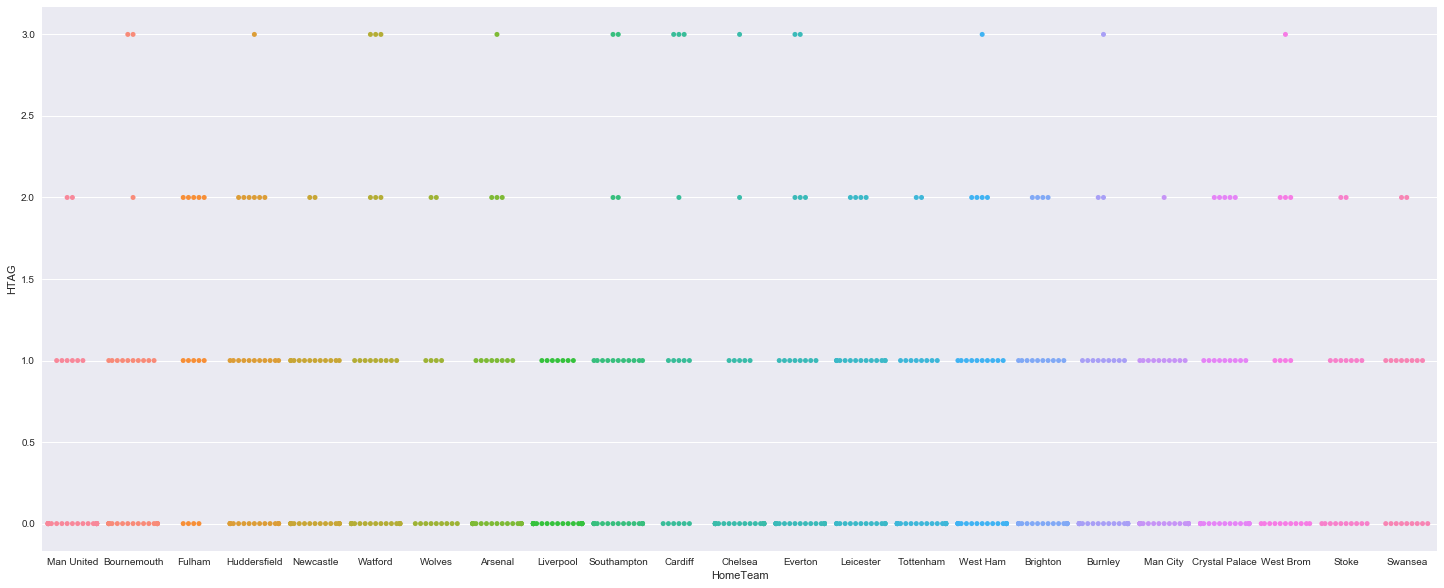

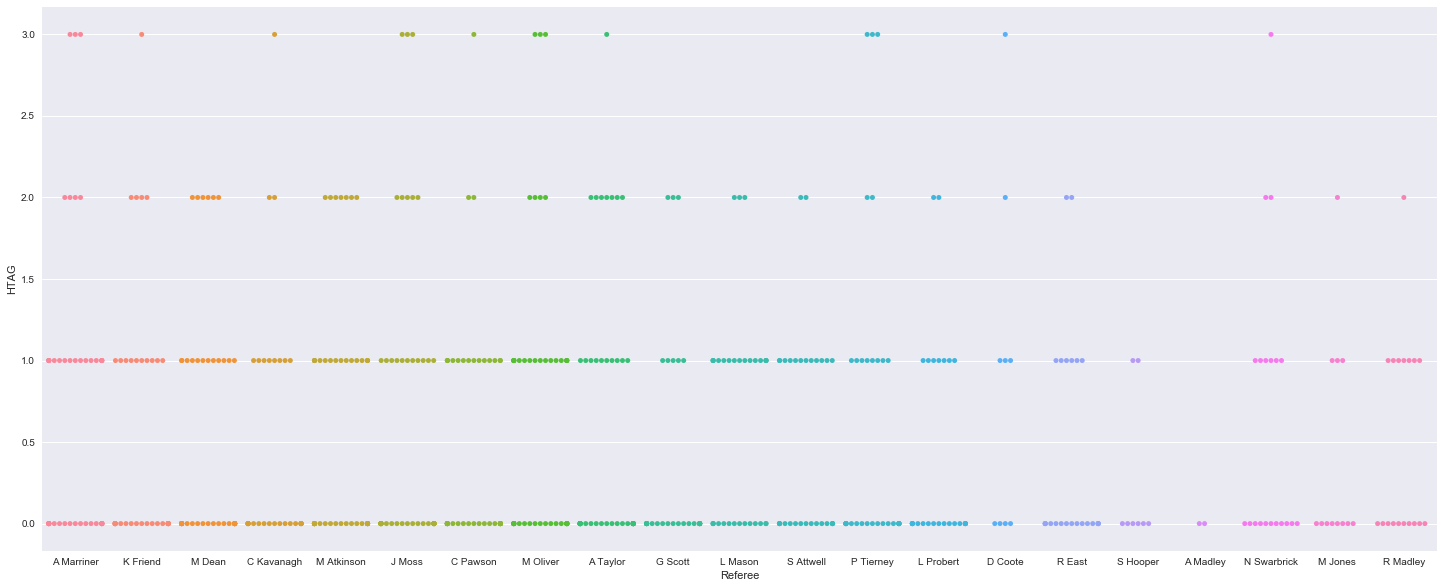

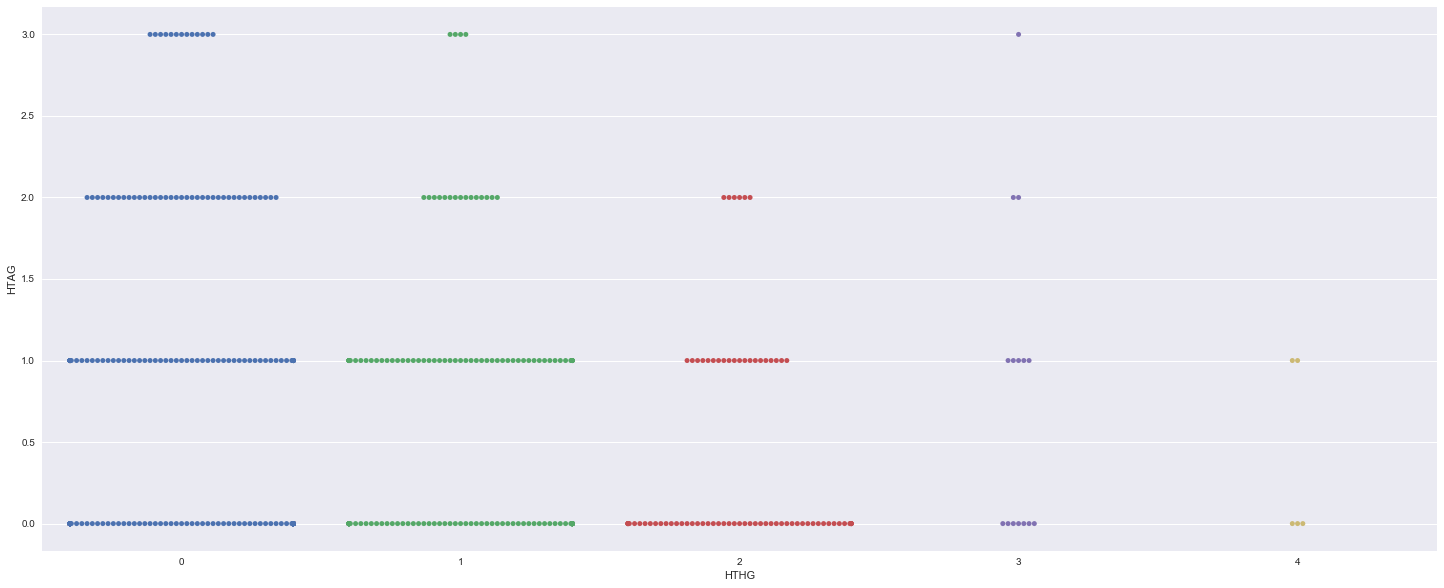

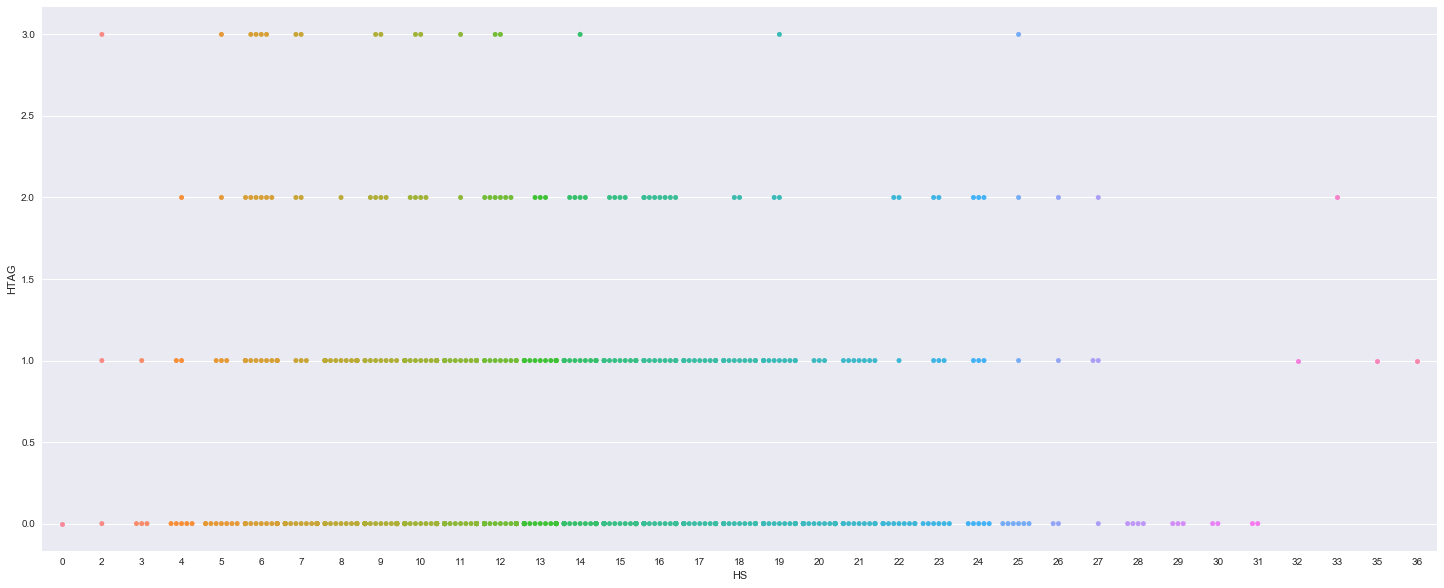

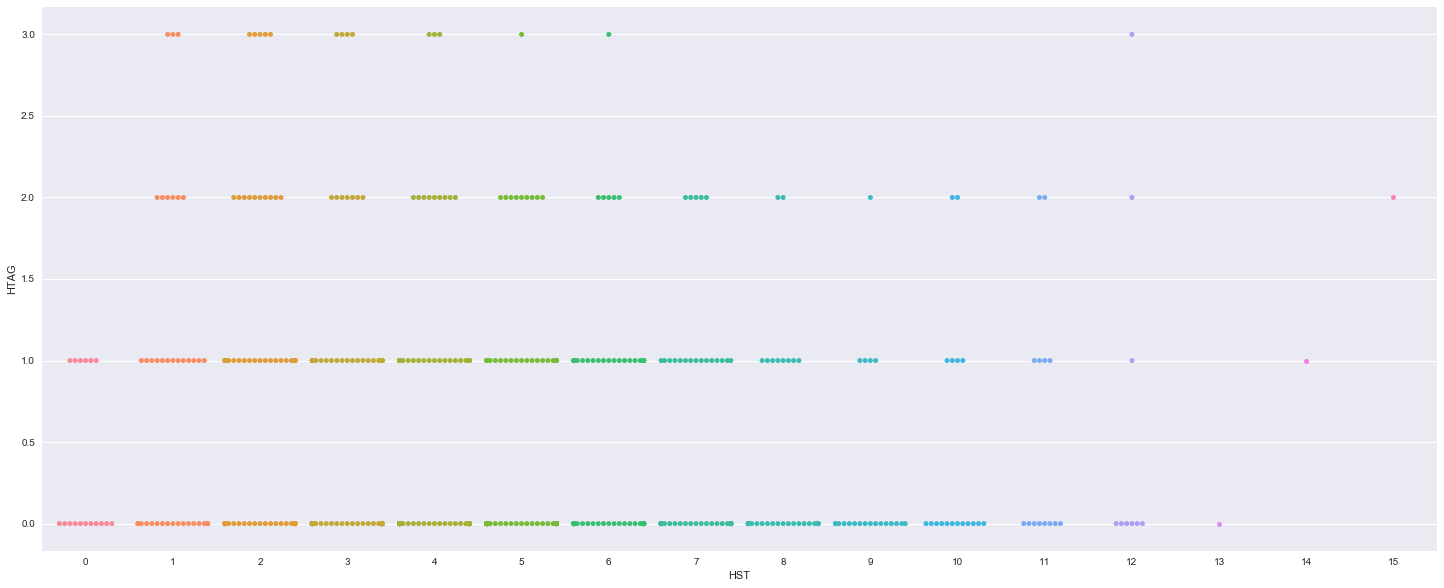

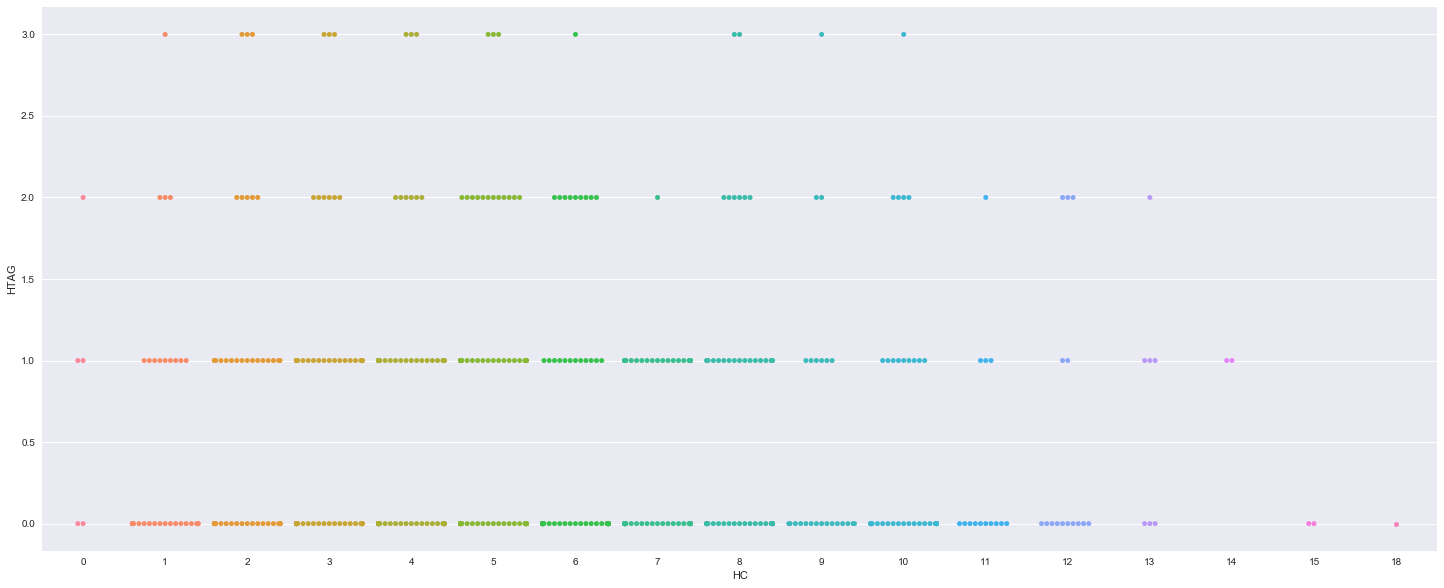

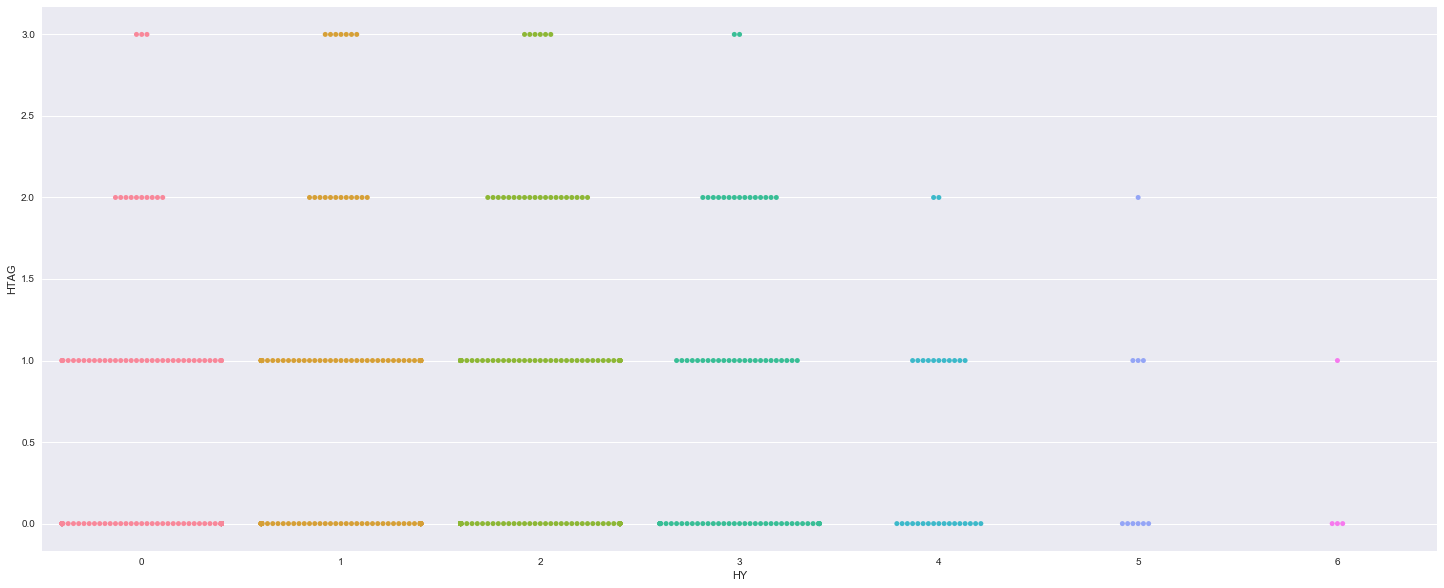

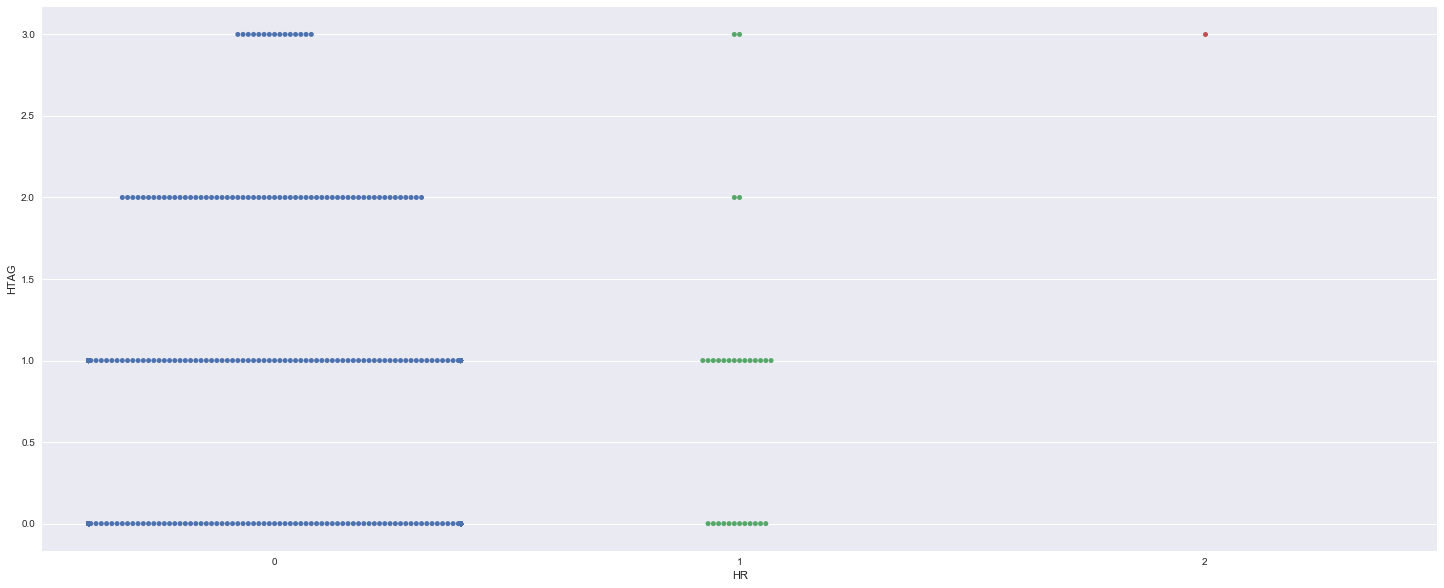

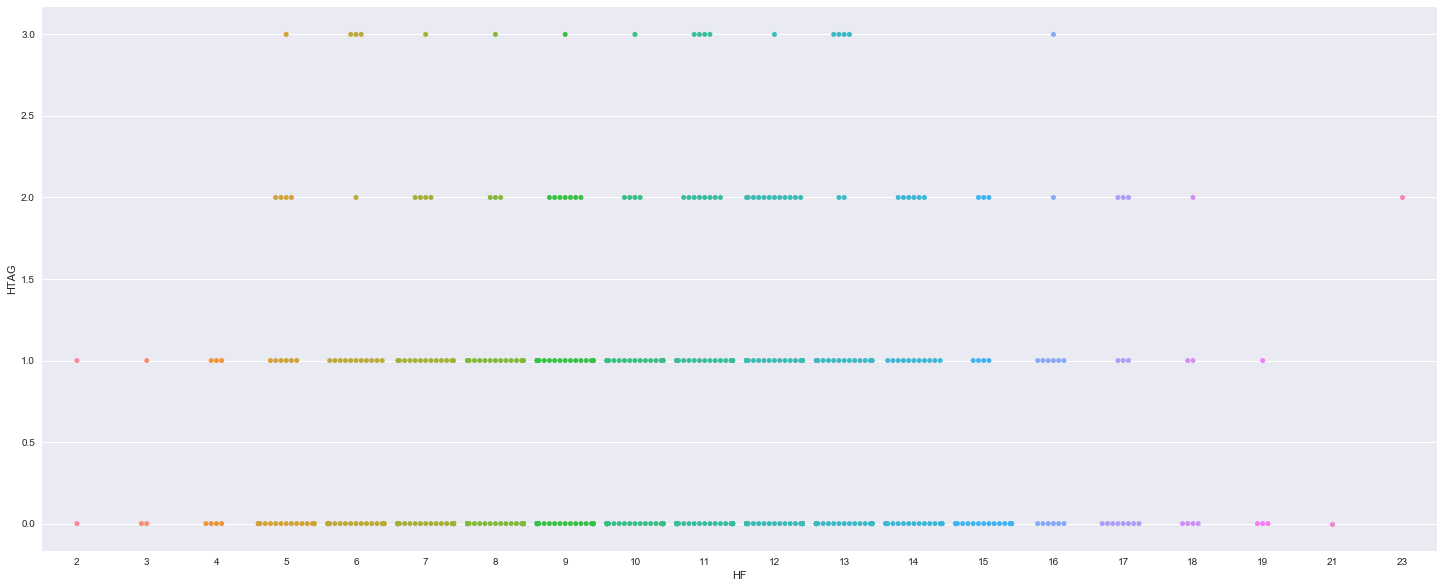

In [23]:
# now lets look at total score swarm plots by home features
home_list = ['HomeTeam', 'Referee','HTHG', 'HS', 
              'HST', 'HC', 'HY', 'HR', 'HF']

for x in home_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.HTAG)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

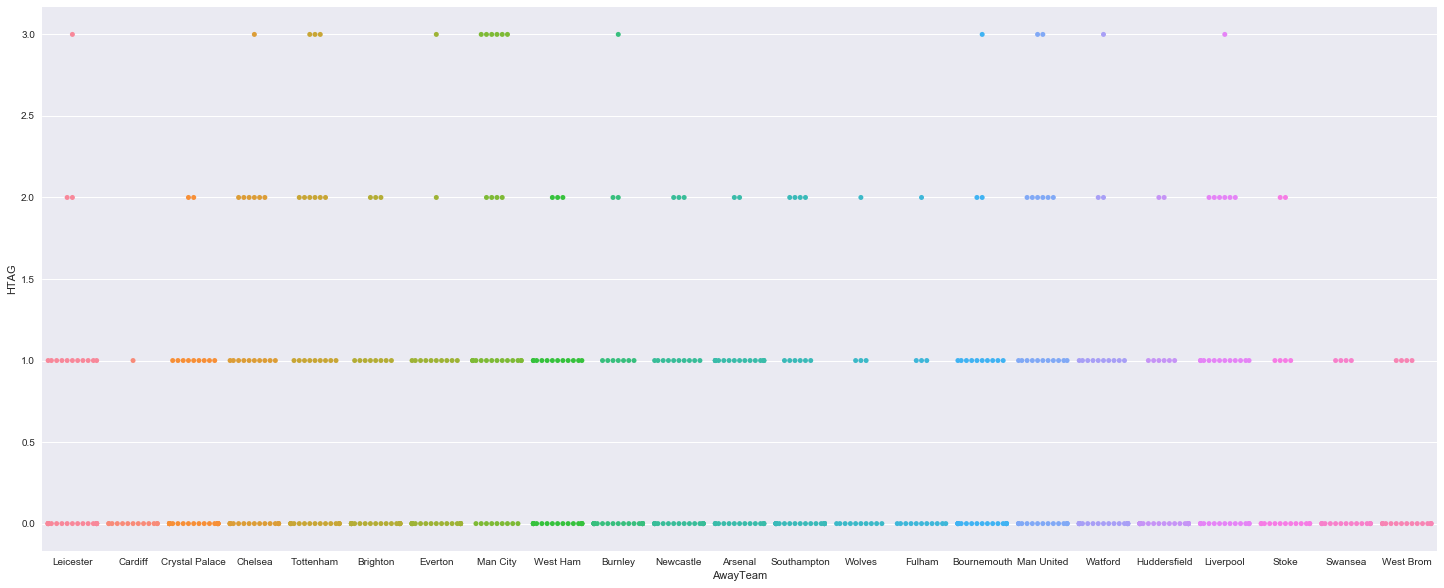

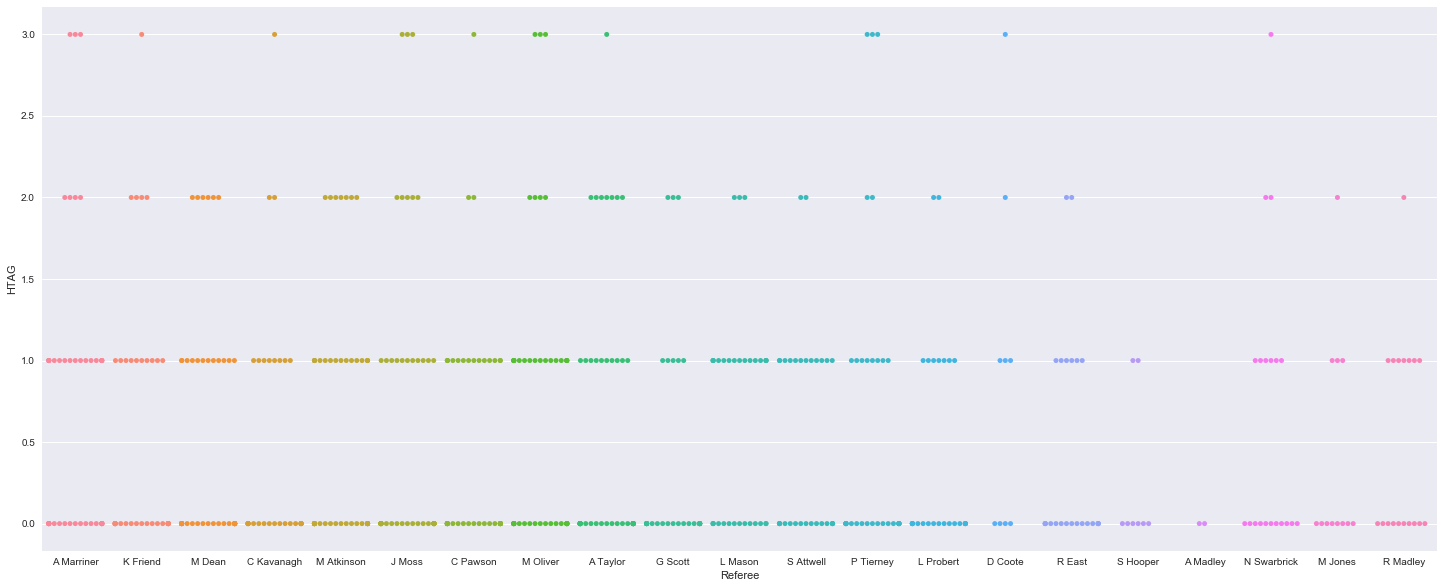

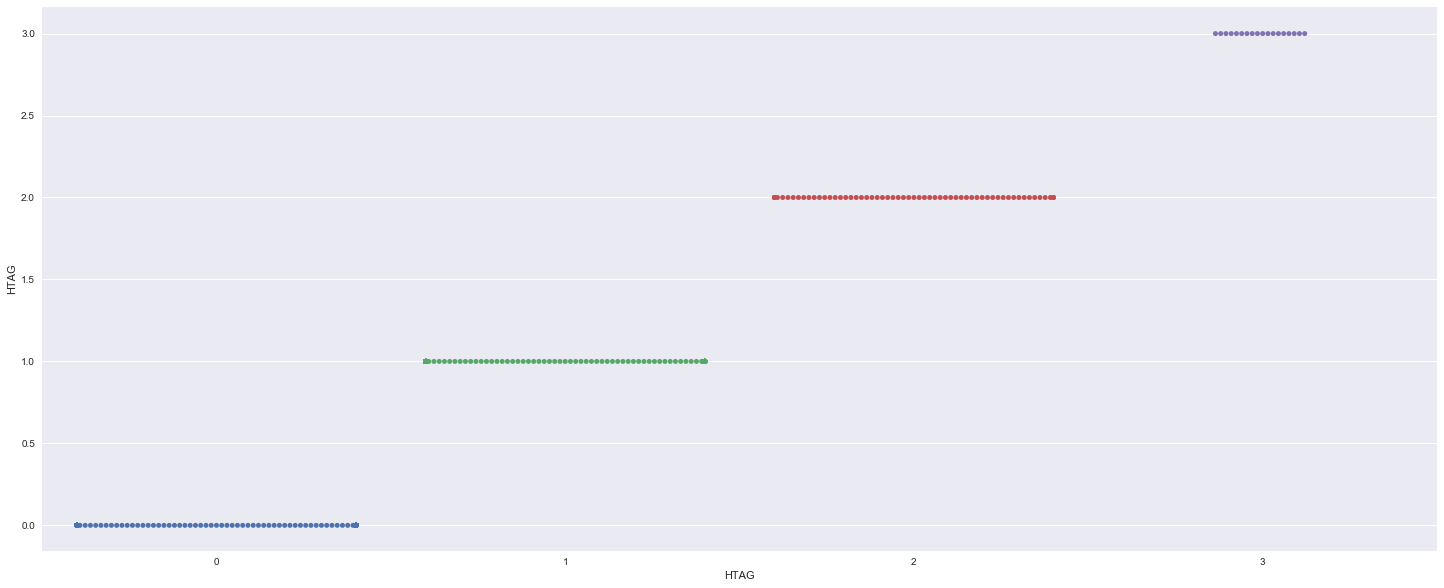

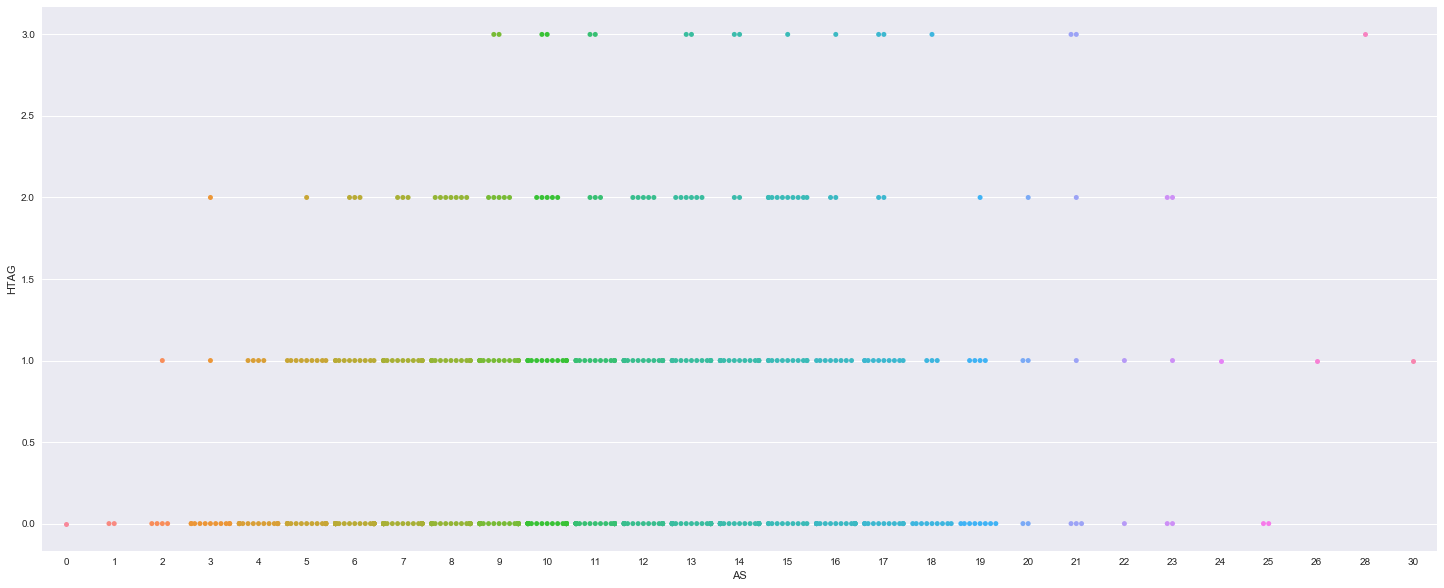

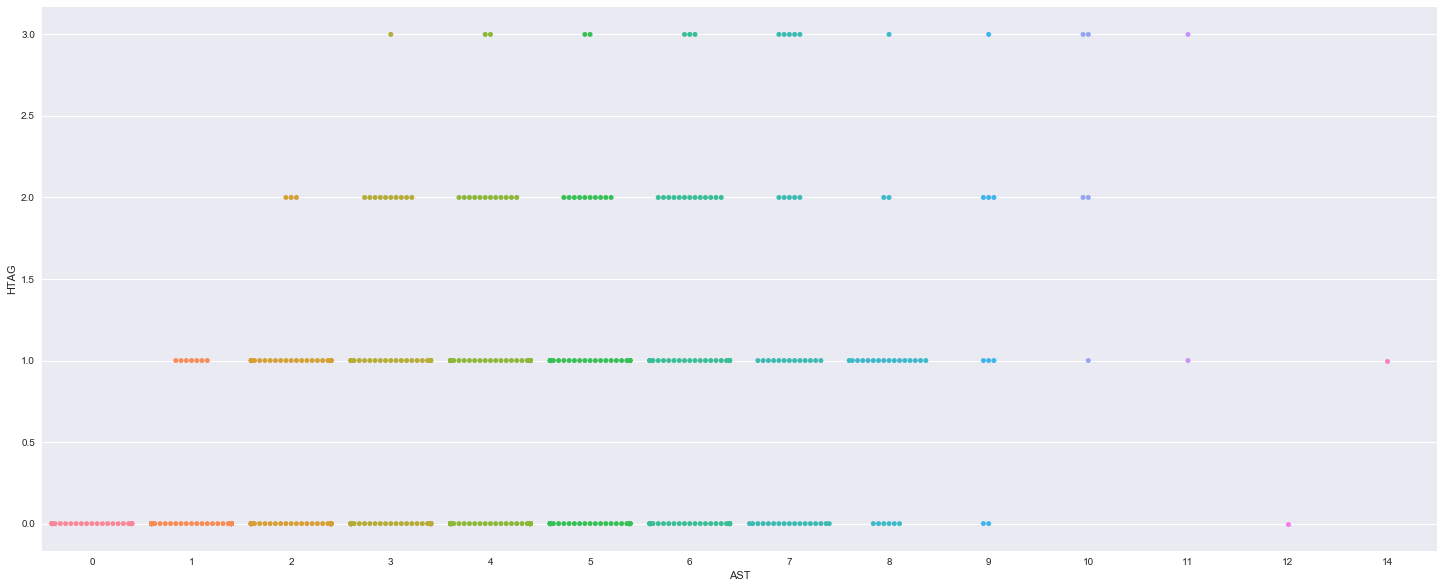

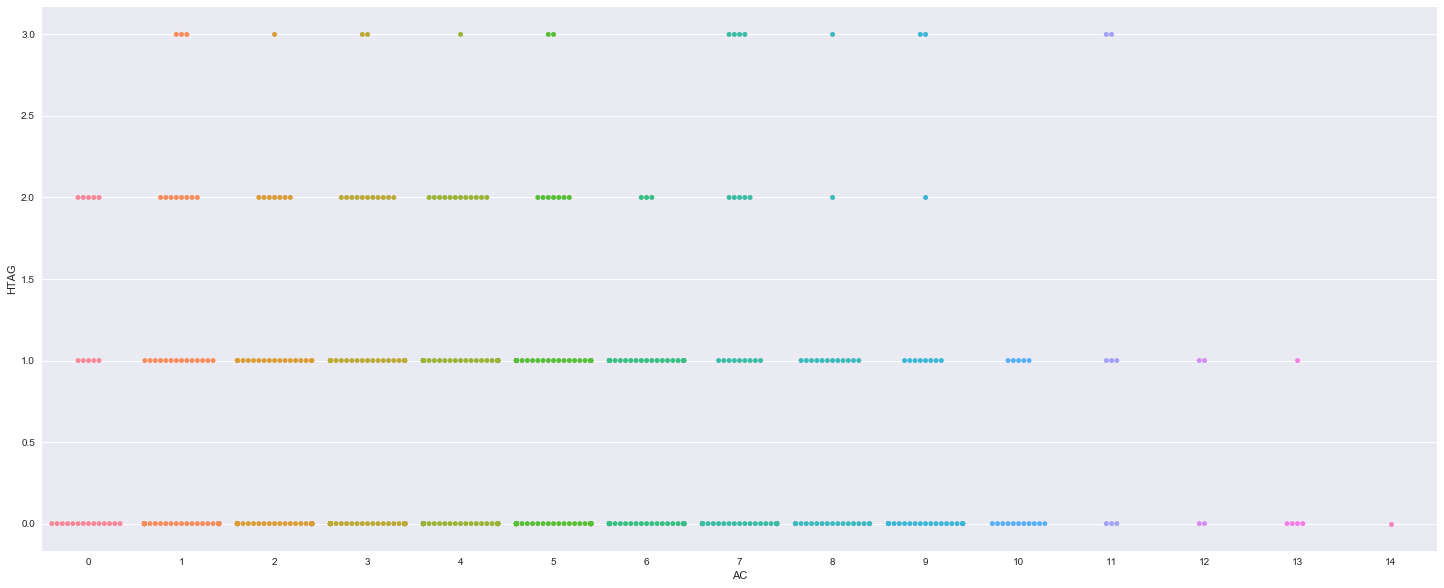

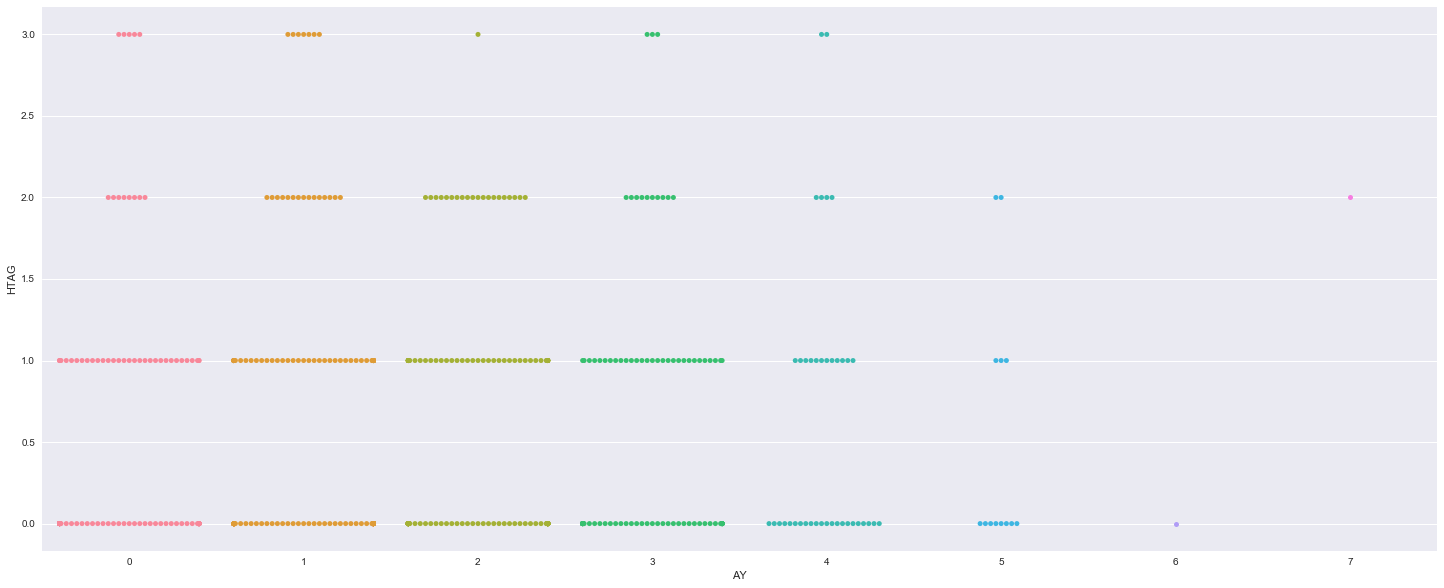

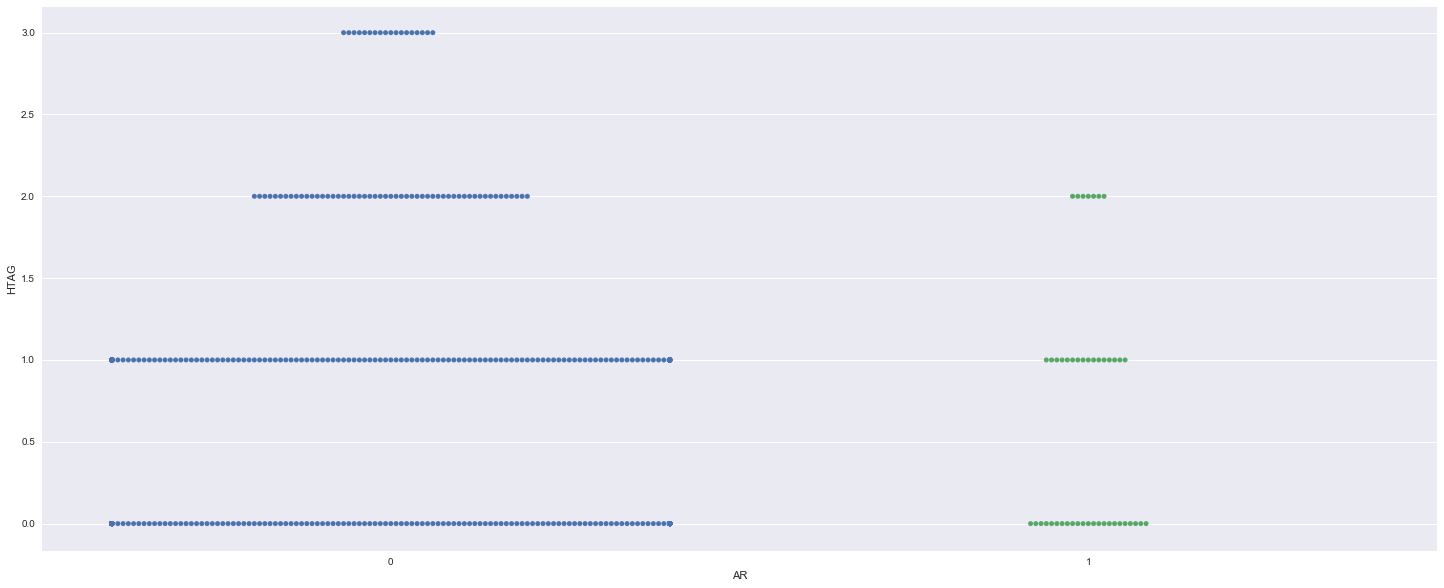

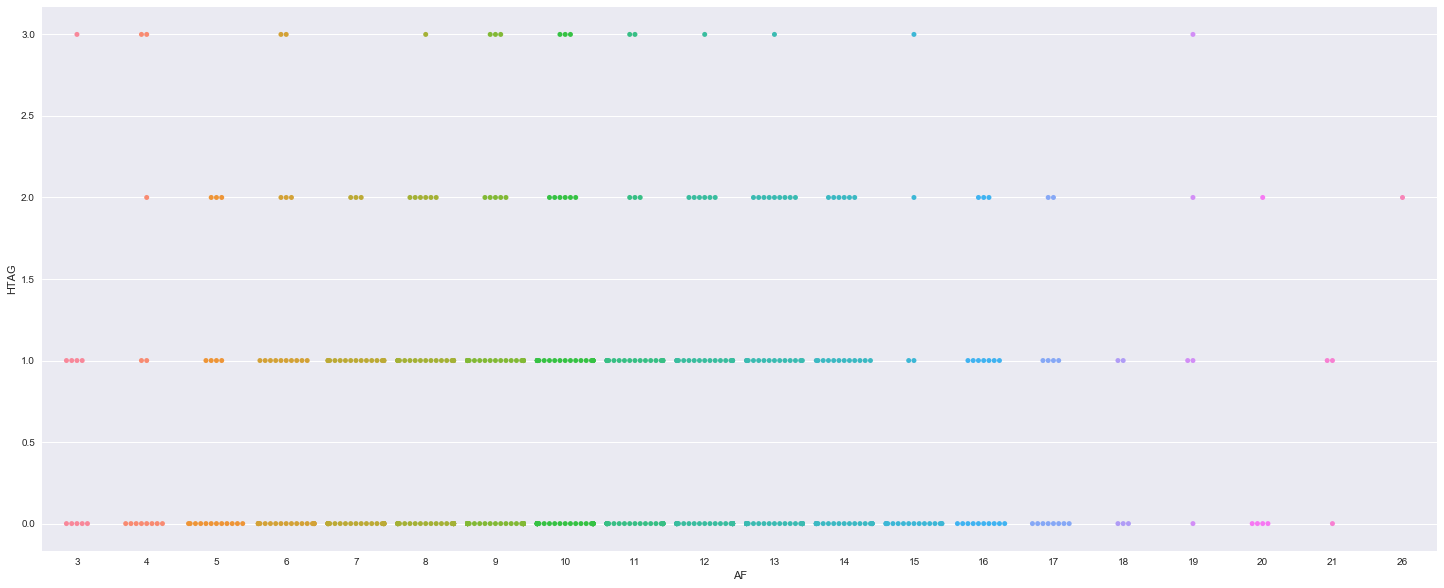

In [24]:
# now lets look at total score swarm plots by away features
away_list = ['AwayTeam', 'Referee','HTAG', 'AS', 
              'AST', 'AC', 'AY', 'AR', 'AF']

for x in away_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.HTAG)

<Figure size 1440x720 with 0 Axes>

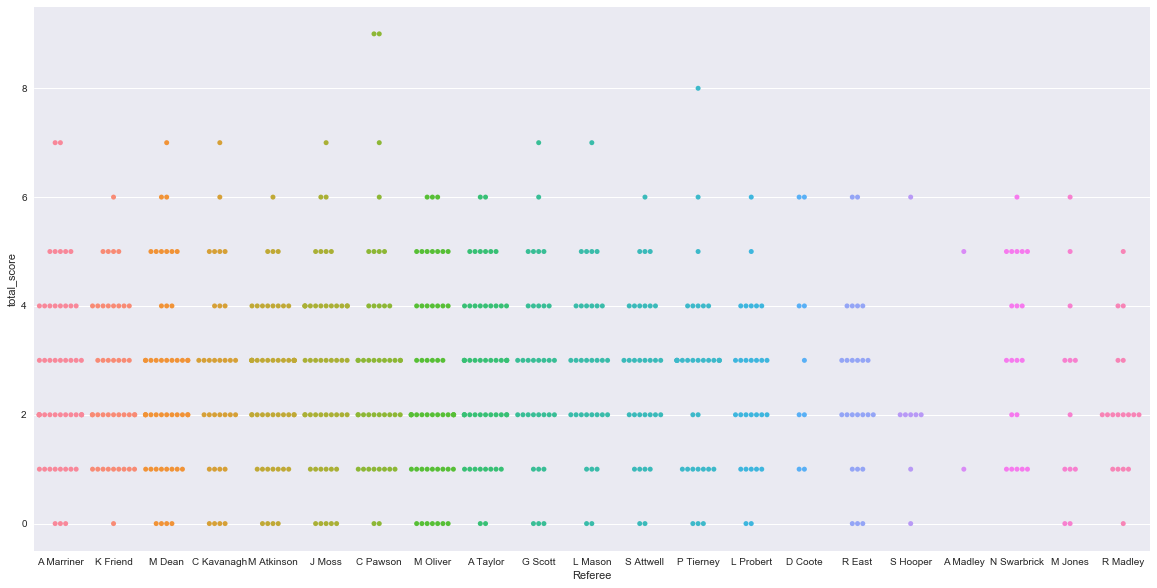

In [25]:
# total score swarmplots by referee
plt.figure(figsize=(20,10)) 
sns.swarmplot(df_total.Referee, df_total.total_score)

<Figure size 1800x720 with 0 Axes>

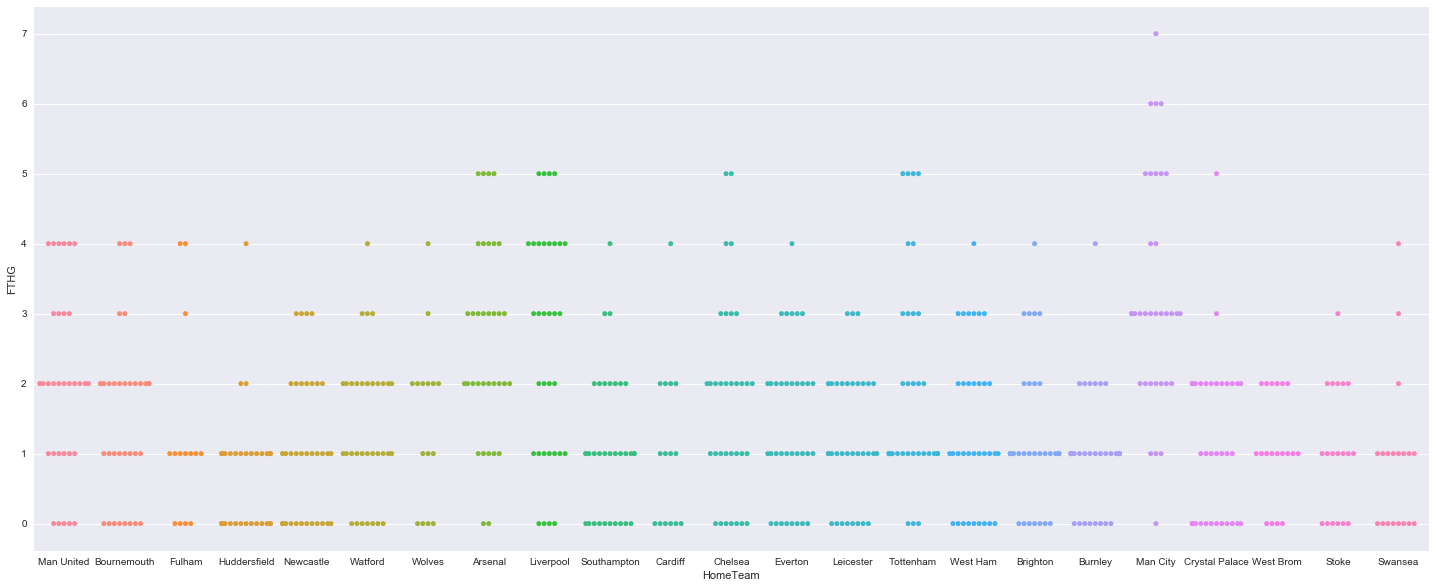

In [26]:
# home score swarmplots by HomeTeam
plt.figure(figsize=(25,10)) 
sns.swarmplot(df_total.HomeTeam, df_total.FTHG)

### Looks like Man City, Man United, and Liverpool (YNWA) have been doing great at home recently which makes sense if you have been following the EPL the past couple seasons

<Figure size 1800x720 with 0 Axes>

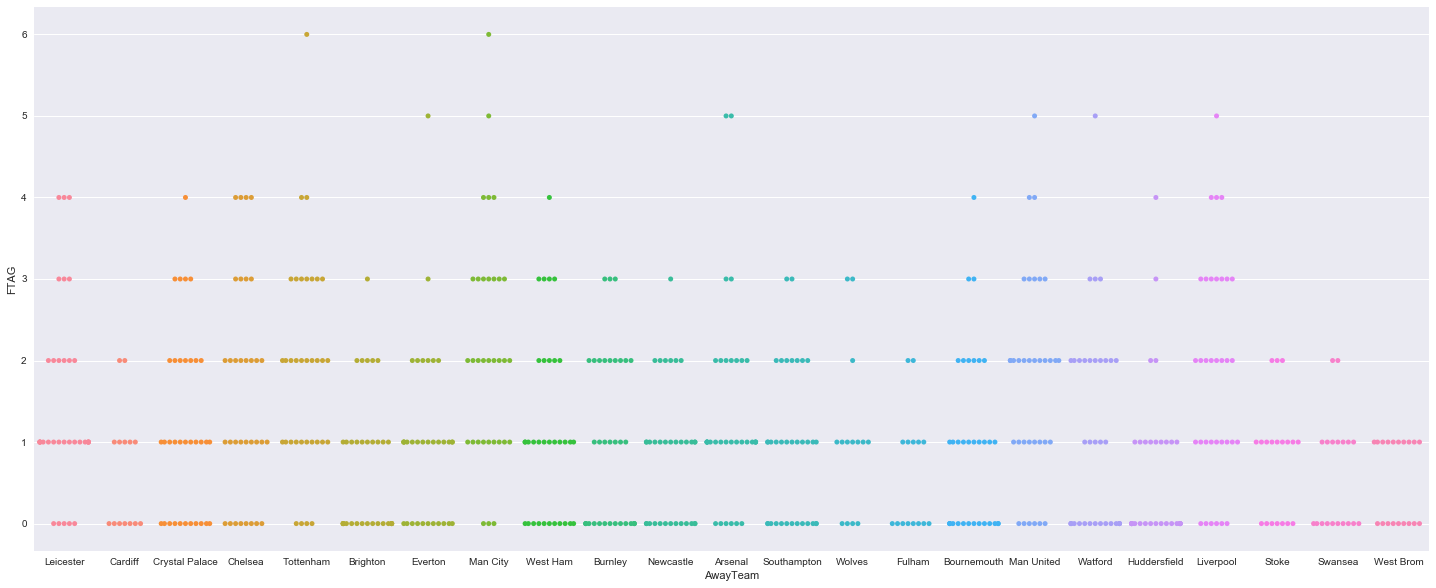

In [27]:
# away score swarmplots by AwayTeam
plt.figure(figsize=(25,10)) 
sns.swarmplot(df_total.AwayTeam, df_total.FTAG)

### looks like Spurs, Man City, and Liverpool (YNWA) have been doing great away from home lately which makes sense if you have been following the EPL the past couple seasons

<Figure size 1440x720 with 0 Axes>

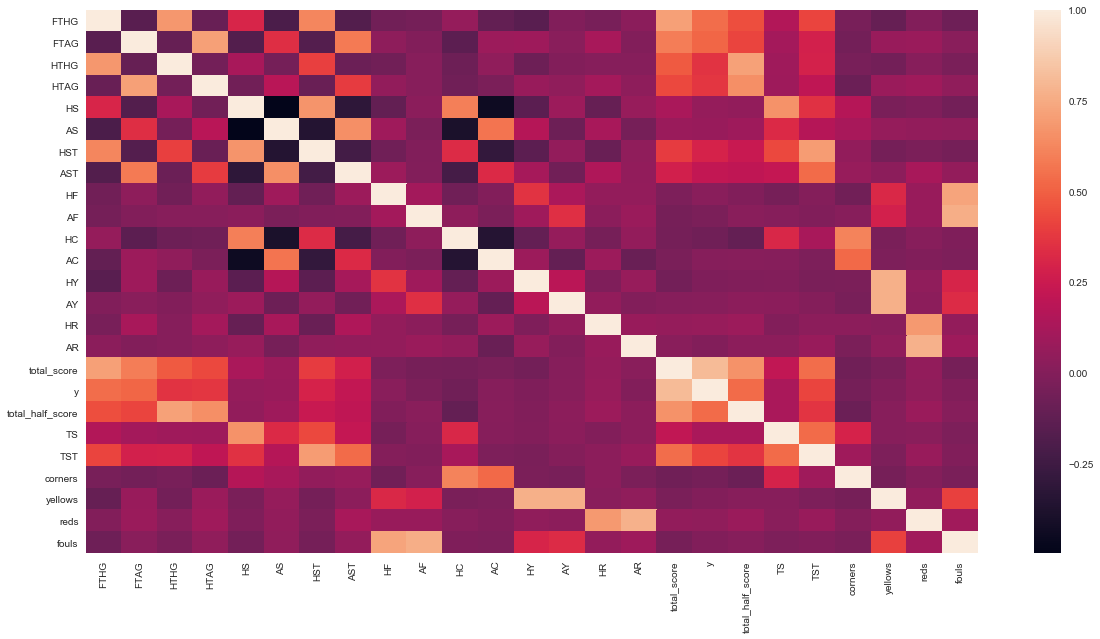

In [28]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df_total.corr())
plt.show()

In [29]:
df_total.insert(loc=0, column='y', 
              value=df_total.y, 
              allow_duplicates=True) # move y to front of dataframe
df_total.info()
df_total.head()
df_total.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 30 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
y                   int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
dtypes: int64(26), object(4)
memory usage: 156.9+ KB


,y,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score,y,total_half_score,TS,TST,corners,yellows,reds,fouls
0,1,2018-08-10,Man United,Leicester,2,1,1,0,A Marriner,8,13,6,4,11,8,2,5,2,1,0,0,3,1,1,21,10,7,3,0,19
1,0,2018-08-11,Bournemouth,Cardiff,2,0,1,0,K Friend,12,10,4,1,11,9,7,4,1,1,0,0,2,0,1,22,5,11,2,0,20
2,0,2018-08-11,Fulham,Crystal Palace,0,2,0,1,M Dean,15,10,6,9,9,11,5,5,1,2,0,0,2,0,1,25,15,10,3,0,20
3,1,2018-08-11,Huddersfield,Chelsea,0,3,0,2,C Kavanagh,6,13,1,4,9,8,2,5,2,1,0,0,3,1,2,19,5,7,3,0,17
4,1,2018-08-11,Newcastle,Tottenham,1,2,1,2,M Atkinson,15,15,2,5,11,12,3,5,2,2,0,0,3,1,3,30,7,8,4,0,23


,y,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score,y,total_half_score,TS,TST,corners,yellows,reds,fouls
664,1,2018-05-13,Newcastle,Chelsea,3,0,1,0,M Atkinson,16,6,6,2,11,10,4,2,0,1,0,0,3,1,1,22,8,6,1,0,21
665,0,2018-05-13,Southampton,Man City,0,1,0,0,A Marriner,8,13,3,2,8,10,1,12,3,1,0,0,1,0,0,21,5,13,4,0,18
666,1,2018-05-13,Swansea,Stoke,1,2,1,2,A Taylor,26,8,11,5,12,9,6,0,1,2,0,0,3,1,3,34,16,6,3,0,21
667,1,2018-05-13,Tottenham,Leicester,5,4,1,2,C Pawson,14,16,6,9,9,13,4,4,1,2,0,0,9,1,3,30,15,8,3,0,22
668,1,2018-05-13,West Ham,Everton,3,1,1,0,G Scott,15,14,4,7,10,13,6,6,0,1,0,0,4,1,1,29,11,12,1,0,23


In [30]:
df_total = df_total.loc[:,~df_total.columns.duplicated()]
df_total.info()
df_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 29 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
dtypes: int64(25), object(4)
memory usage: 151.6+ KB


,y,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score,total_half_score,TS,TST,corners,yellows,reds,fouls
0,1,2018-08-10,Man United,Leicester,2,1,1,0,A Marriner,8,13,6,4,11,8,2,5,2,1,0,0,3,1,21,10,7,3,0,19
1,0,2018-08-11,Bournemouth,Cardiff,2,0,1,0,K Friend,12,10,4,1,11,9,7,4,1,1,0,0,2,1,22,5,11,2,0,20
2,0,2018-08-11,Fulham,Crystal Palace,0,2,0,1,M Dean,15,10,6,9,9,11,5,5,1,2,0,0,2,1,25,15,10,3,0,20
3,1,2018-08-11,Huddersfield,Chelsea,0,3,0,2,C Kavanagh,6,13,1,4,9,8,2,5,2,1,0,0,3,2,19,5,7,3,0,17
4,1,2018-08-11,Newcastle,Tottenham,1,2,1,2,M Atkinson,15,15,2,5,11,12,3,5,2,2,0,0,3,3,30,7,8,4,0,23


### Although a lot of the features we have analyze so far are very interesting in how they relate to our binary variable we are intending to predict, astute machine learning engineers following along closely will have noticed that a number of these features provided with each sample will not be available to be used in our model to predict whether or not a game will have more than 2.5 goals at the time before the game.  For example, we will not know how many goals an away or home side will score in the game we want to predict until after the game has occured.  However, we can draw useful information from these features by calculating features such as a particular teams last total goals scored in last 5 games (we can also do the same for other features like shots and # of cards).  

### lets start creating a function to create these fields as it will be tedious given the structure of the data (away/home, yet last 5 scores doesn't care about home or away

In [31]:
df_list = set(df.HomeTeam.unique().tolist())
df2_list = set(df2.AwayTeam.unique().tolist())
df_set = df_list.union(df2_list)
teamList = list(df_set)
teamList
len(teamList) # check # teams

['Leicester',
 'Brighton',
 'Man United',
 'Wolves',
 'Crystal Palace',
 'Newcastle',
 'Huddersfield',
 'Man City',
 'Tottenham',
 'Swansea',
 'Watford',
 'West Ham',
 'Everton',
 'West Brom',
 'Bournemouth',
 'Cardiff',
 'Burnley',
 'Arsenal',
 'Liverpool',
 'Stoke',
 'Fulham',
 'Southampton',
 'Chelsea']

23

In [32]:
df_total = df_total.sort_values(by=['Date'], ascending=True).reset_index(drop=True)
df_total['idx_test'] = df_total.index
df_total.info()
df_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 30 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
idx_test            int64
dtypes: int64(26), object(4)
memory usage: 156.9+ KB


,y,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score,total_half_score,TS,TST,corners,yellows,reds,fouls,idx_test
0,1,2017-08-11,Arsenal,Leicester,4,3,2,2,M Dean,27,6,10,3,9,12,9,4,0,1,0,0,7,4,33,13,13,1,0,21,0
1,0,2017-08-12,Brighton,Man City,0,2,0,0,M Oliver,6,14,2,4,6,9,3,10,0,2,0,0,2,0,20,6,13,2,0,15,1
2,1,2017-08-12,Chelsea,Burnley,2,3,0,3,C Pawson,19,10,6,5,16,11,8,5,3,3,2,0,5,3,29,11,13,6,2,27,2
3,1,2017-08-12,Crystal Palace,Huddersfield,0,3,0,2,J Moss,14,8,4,6,7,19,12,9,1,3,0,0,3,2,22,10,21,4,0,26,3
4,0,2017-08-12,Everton,Stoke,1,0,1,0,N Swarbrick,9,9,4,1,13,10,6,7,1,1,0,0,1,1,18,5,13,2,0,23,4


In [33]:
def last5_byteam(df=df_total, team='Arsenal'):
    dfteam = df_total.loc[((df_total.HomeTeam == team) | (df_total.AwayTeam == team)), :]
    dfteam = dfteam.drop(columns=['Referee'])
    dfteam.head()
    dfteam['team'] = team

    def goals(row, home, away):
        if row["HomeTeam"] == team:
            return row[home]
        elif row["AwayTeam"] == team:
            return row[away]

    dfteam['goals'] = dfteam.apply(goals, axis=1, home='FTHG', away='FTAG')
    dfteam['h_goals'] = dfteam.apply(goals, axis=1, home='HTHG', away='HTAG')
    dfteam['shots'] = dfteam.apply(goals, axis=1, home='HS', away='AS')
    dfteam['shots_on'] = dfteam.apply(goals, axis=1, home='HST', away='AST')
    dfteam['fls'] = dfteam.apply(goals, axis=1, home='HF', away='AF')
    dfteam['corns'] = dfteam.apply(goals, axis=1, home='HC', away='AC')
    dfteam['yells'] = dfteam.apply(goals, axis=1, home='HY', away='AY')
    dfteam['rds'] = dfteam.apply(goals, axis=1, home='HR', away='AR')
    
    dfteam = dfteam.sort_values(by=['Date']).reset_index(drop=True)
    
    dfteam['last5goals'] = dfteam.goals.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5Hgoals'] = dfteam.h_goals.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5shots'] = dfteam.shots.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5shots_on'] = dfteam.shots_on.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5fls'] = dfteam.fls.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5corns'] = dfteam.corns.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5yells'] = dfteam.yells.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5reds'] = dfteam.rds.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5total_goals'] = dfteam.total_score.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5total_Hgoals'] = dfteam.total_half_score.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam2 = dfteam[['Date','team', 'last5goals', 'last5Hgoals',
                      'last5shots', 'last5shots_on', 'last5fls',
                      'last5corns', 'last5yells', 'last5reds',
                      'last5total_goals', 'last5total_Hgoals']] # drop columns don't need
    
    return dfteam2

df_dict = {}
for team in teamList:
    df_dict[team] = last5_byteam(team=team)
    
df_dict['Man United'].head()
len(df_dict) # check df # matches # of teams

,Date,team,last5goals,last5Hgoals,last5shots,last5shots_on,last5fls,last5corns,last5yells,last5reds,last5total_goals,last5total_Hgoals
0,2017-08-13,Man United,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-08-19,Man United,4.0,1.0,22.0,6.0,19.0,11.0,2.0,0.0,4.0,1.0
2,2017-08-26,Man United,8.0,2.0,39.0,14.0,30.0,16.0,3.0,0.0,8.0,2.0
3,2017-09-09,Man United,10.0,2.0,61.0,21.0,38.0,25.0,4.0,0.0,10.0,2.0
4,2017-09-17,Man United,12.0,3.0,79.0,29.0,48.0,36.0,4.0,0.0,14.0,4.0


23

In [71]:
df_total = df_total.sort_values(by=['Date'], ascending=True).reset_index(drop=True)
df_total['idx_test'] = df_total.index
df_total.to_csv('testv2.csv')
df_total.info()
df_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 30 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
idx_test            int64
dtypes: int64(26), object(4)
memory usage: 156.9+ KB


,y,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score,total_half_score,TS,TST,corners,yellows,reds,fouls,idx_test
0,1,2017-08-11,Arsenal,Leicester,4,3,2,2,M Dean,27,6,10,3,9,12,9,4,0,1,0,0,7,4,33,13,13,1,0,21,0
1,0,2017-08-12,Brighton,Man City,0,2,0,0,M Oliver,6,14,2,4,6,9,3,10,0,2,0,0,2,0,20,6,13,2,0,15,1
2,1,2017-08-12,Chelsea,Burnley,2,3,0,3,C Pawson,19,10,6,5,16,11,8,5,3,3,2,0,5,3,29,11,13,6,2,27,2
3,1,2017-08-12,Crystal Palace,Huddersfield,0,3,0,2,J Moss,14,8,4,6,7,19,12,9,1,3,0,0,3,2,22,10,21,4,0,26,3
4,0,2017-08-12,Everton,Stoke,1,0,1,0,N Swarbrick,9,9,4,1,13,10,6,7,1,1,0,0,1,1,18,5,13,2,0,23,4


### joining all these team unique DFs to our original DF will be process and time intensive and will be tedious using pandas programming, so lets use PySpark so we can programmatically write SQL statements to accomplish finally creating these fields easily.

In [35]:
# find spark
import findspark
findspark.init()

# build spark session
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("ddapp") \
    .getOrCreate()

# spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [60]:
# create SparkDataFrame from df_total
sp_df = spark.createDataFrame(df_total)
sp_df.show(3)

# build dict with spark DataFrames
sdf_dict = {}
for k, v in df_dict.items():
    sdf_dict[k] = spark.createDataFrame(v)

sdf_dict['Man United'].show(3)
type(sdf_dict['Man United']) # verify spark dataframe type
len(sdf_dict) # check df # matches # of teams

+---+----------+--------+---------+----+----+----+----+--------+---+---+---+---+---+---+---+---+---+---+---+---+-----------+----------------+---+---+-------+-------+----+-----+--------+
|  y|      Date|HomeTeam| AwayTeam|FTHG|FTAG|HTHG|HTAG| Referee| HS| AS|HST|AST| HF| AF| HC| AC| HY| AY| HR| AR|total_score|total_half_score| TS|TST|corners|yellows|reds|fouls|idx_test|
+---+----------+--------+---------+----+----+----+----+--------+---+---+---+---+---+---+---+---+---+---+---+---+-----------+----------------+---+---+-------+-------+----+-----+--------+
|  1|2017-08-11| Arsenal|Leicester|   4|   3|   2|   2|  M Dean| 27|  6| 10|  3|  9| 12|  9|  4|  0|  1|  0|  0|          7|               4| 33| 13|     13|      1|   0|   21|       0|
|  0|2017-08-12|Brighton| Man City|   0|   2|   0|   0|M Oliver|  6| 14|  2|  4|  6|  9|  3| 10|  0|  2|  0|  0|          2|               0| 20|  6|     13|      2|   0|   15|       1|
|  1|2017-08-12| Chelsea|  Burnley|   2|   3|   0|   3|C Pawson| 19| 1

pyspark.sql.dataframe.DataFrame

23

In [37]:
# create list of tempviews for spark sql
spsql_list = []
for team in teamList:
    sdf_dict[team].createOrReplaceTempView((str(team).replace(" ", "_")+'_sql'))
    spsql_list.append(((str(team).replace(" ", "_")+'_sql')))

spsql_list

['Leicester_sql',
 'Brighton_sql',
 'Man_United_sql',
 'Wolves_sql',
 'Crystal_Palace_sql',
 'Newcastle_sql',
 'Huddersfield_sql',
 'Man_City_sql',
 'Tottenham_sql',
 'Swansea_sql',
 'Watford_sql',
 'West_Ham_sql',
 'Everton_sql',
 'West_Brom_sql',
 'Bournemouth_sql',
 'Cardiff_sql',
 'Burnley_sql',
 'Arsenal_sql',
 'Liverpool_sql',
 'Stoke_sql',
 'Fulham_sql',
 'Southampton_sql',
 'Chelsea_sql']

In [38]:
# build each teams "last 5" dataframe 
spdf_dict = {}
for s in spsql_list:
    sp_df.createOrReplaceTempView("spdf_sql")
    query = """select a.*, 
                 b.team, 
                 
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5goals else 0 end) as homeLast5goals,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5goals else 0 end) as awayLast5goals,
                 
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5Hgoals else 0 end) as homeLast5Hgoals,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5Hgoals else 0 end) as awayLast5Hgoals,
                      
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5shots else 0 end) as homeLast5shots,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5shots else 0 end) as awayLast5shots,
                      
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5shots_on else 0 end) as homeLast5shots_on,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5shots_on else 0 end) as awayLast5shots_on,    
                      
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5fls else 0 end) as homeLast5fls,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5fls else 0 end) as awayLast5fls,
                  
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5yells else 0 end) as homeLast5yells,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5yells else 0 end) as awayLast5yells, 
                      
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5reds else 0 end) as homeLast5reds,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5reds else 0 end) as awayLast5reds,
                 
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5corns else 0 end) as homeLast5corns,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5corns else 0 end) as awayLast5corns, 
                      
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5total_goals else 0 end) as homeLast5total_goals,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5total_goals else 0 end) as awayLast5total_goals,
                                            
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5total_Hgoals else 0 end) as homeLast5total_Hgoals,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5total_Hgoals else 0 end) as awayLast5total_Hgoals
               from spdf_sql as a 
                 left join {} as b 
                   on a.Date = b.Date and (a.HomeTeam = b.team OR a.AwayTeam = b.team)
                order by a.Date""".format(s)
    sqlDF = spark.sql(query)
    sqlDF[['y', 'Date', 'HomeTeam', 'AwayTeam', 'team', \
           'FTHG', 'FTAG', 'total_score', 
           'homeLast5goals', 'awayLast5goals']].show(20)
    type(sqlDF)
    spdf_dict[s] = sqlDF
    spdf_dict.keys()

+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|     team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|Leicester|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|     null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|     null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|     null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|     null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|     null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql'])

+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|    team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|    null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|Brighton|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|    null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|    null|   0|   3|          3|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|    null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|    null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|     West Br

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql'])

+---+----------+--------------+--------------+----------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|      team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+----------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|      null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|      null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|      null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|      null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|      null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|      null|   0|   0|          0|           0.0|           0.0|
|  1|2017-

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql'])

+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|null|   1|   0|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql'])

+---+----------+--------------+--------------+--------------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|          team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+--------------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|          null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|          null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|          null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|          null|   2|   3|          5|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|          null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|          null|   1|   0|          1|     

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql'])

+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|     team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|     null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|     null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|     null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|     null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|     null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|     null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql'])

+---+----------+--------------+--------------+------------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|        team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+------------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|        null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|        null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|        null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|        null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|        null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|Huddersfield|   0|   3|          3|           0.0|        

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql'])

+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|    team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|    null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|    null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|    null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|    null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|Man City|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|    null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|     West Br

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql'])

+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|     team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|     null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|     null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|     null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|     null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|     null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|     null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|   null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|Swansea|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|   null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|   null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bou

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql', 'Swansea_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|   null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|   null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|Watford|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|   null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|   null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Hudd

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql', 'Swansea_sql', 'Watford_sql'])

+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|    team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|    null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|    null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|    null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|    null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|    null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|    null|   0|   3|          3|           0.0|           0.0|
|  1|2017-08-12|       Chels

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql', 'Swansea_sql', 'Watford_sql', 'West_Ham_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|   null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|   null|   2|   3|          5|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|   null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|   null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|   null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Hudd

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql', 'Swansea_sql', 'Watford_sql', 'West_Ham_sql', 'Everton_sql'])

+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|     team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|     null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|     null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|     null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|     null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|West Brom|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|     null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql', 'Swansea_sql', 'Watford_sql', 'West_Ham_sql', 'Everton_sql', 'West_Brom_sql'])

+---+----------+--------------+--------------+-----------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|       team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-----------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|       null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|Bournemouth|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|       null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|       null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|       null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|       null|   0|   3|          3|           0.0|           0.0|
|

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql', 'Swansea_sql', 'Watford_sql', 'West_Ham_sql', 'Everton_sql', 'West_Brom_sql', 'Bournemouth_sql'])

+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|null|   0|   3|          3|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|null|   1|   0|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql', 'Swansea_sql', 'Watford_sql', 'West_Ham_sql', 'Everton_sql', 'West_Brom_sql', 'Bournemouth_sql', 'Cardiff_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|   null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|Burnley|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|   null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|   null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|   null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Hudd

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql', 'Swansea_sql', 'Watford_sql', 'West_Ham_sql', 'Everton_sql', 'West_Brom_sql', 'Bournemouth_sql', 'Cardiff_sql', 'Burnley_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|Arsenal|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|   null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|   null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|   null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|   null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|       Everton|      

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql', 'Swansea_sql', 'Watford_sql', 'West_Ham_sql', 'Everton_sql', 'West_Brom_sql', 'Bournemouth_sql', 'Cardiff_sql', 'Burnley_sql', 'Arsenal_sql'])

+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|     team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|     null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|Liverpool|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|     null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|     null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|     null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|     null|   2|   3|          5|           0.0|           0.0|
|  1|2017-08-12|Cry

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql', 'Swansea_sql', 'Watford_sql', 'West_Ham_sql', 'Everton_sql', 'West_Brom_sql', 'Bournemouth_sql', 'Cardiff_sql', 'Burnley_sql', 'Arsenal_sql', 'Liverpool_sql'])

+---+----------+--------------+--------------+-----+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam| team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-----+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester| null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley| null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City| null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea| null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool| null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth| null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield| null|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql', 'Swansea_sql', 'Watford_sql', 'West_Ham_sql', 'Everton_sql', 'West_Brom_sql', 'Bournemouth_sql', 'Cardiff_sql', 'Burnley_sql', 'Arsenal_sql', 'Liverpool_sql', 'Stoke_sql'])

+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|null|   1|   0|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql', 'Swansea_sql', 'Watford_sql', 'West_Ham_sql', 'Everton_sql', 'West_Brom_sql', 'Bournemouth_sql', 'Cardiff_sql', 'Burnley_sql', 'Arsenal_sql', 'Liverpool_sql', 'Stoke_sql', 'Fulham_sql'])

+---+----------+--------------+--------------+-----------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|       team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-----------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|       null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|       null|   2|   3|          5|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|       null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|       null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|       null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|Southampton|   0|   0|          0|           0.0|           0.0|
|

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql', 'Swansea_sql', 'Watford_sql', 'West_Ham_sql', 'Everton_sql', 'West_Brom_sql', 'Bournemouth_sql', 'Cardiff_sql', 'Burnley_sql', 'Arsenal_sql', 'Liverpool_sql', 'Stoke_sql', 'Fulham_sql', 'Southampton_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|   null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|   null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|   null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|   null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Hudd

pyspark.sql.dataframe.DataFrame

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql', 'Swansea_sql', 'Watford_sql', 'West_Ham_sql', 'Everton_sql', 'West_Brom_sql', 'Bournemouth_sql', 'Cardiff_sql', 'Burnley_sql', 'Arsenal_sql', 'Liverpool_sql', 'Stoke_sql', 'Fulham_sql', 'Southampton_sql', 'Chelsea_sql'])

In [41]:
pandas_dict = {}
for key, spark_sqlDF in spdf_dict.items():
    pandas_dict[key] = spdf_dict[key].toPandas()
    
pandas_dict['Arsenal_sql'].head()
pandas_dict['Arsenal_sql'].info()
df_total.head()
df_total.info()

,y,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score,total_half_score,TS,TST,corners,yellows,reds,fouls,idx_test,team,homeLast5goals,awayLast5goals,homeLast5Hgoals,awayLast5Hgoals,homeLast5shots,awayLast5shots,homeLast5shots_on,awayLast5shots_on,homeLast5fls,awayLast5fls,homeLast5yells,awayLast5yells,homeLast5reds,awayLast5reds,homeLast5corns,awayLast5corns,homeLast5total_goals,awayLast5total_goals,homeLast5total_Hgoals,awayLast5total_Hgoals
0,1,2017-08-11,Arsenal,Leicester,4,3,2,2,M Dean,27,6,10,3,9,12,9,4,0,1,0,0,7,4,33,13,13,1,0,21,0,Arsenal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2017-08-12,Brighton,Man City,0,2,0,0,M Oliver,6,14,2,4,6,9,3,10,0,2,0,0,2,0,20,6,13,2,0,15,1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2017-08-12,Chelsea,Burnley,2,3,0,3,C Pawson,19,10,6,5,16,11,8,5,3,3,2,0,5,3,29,11,13,6,2,27,2,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2017-08-12,Crystal Palace,Huddersfield,0,3,0,2,J Moss,14,8,4,6,7,19,12,9,1,3,0,0,3,2,22,10,21,4,0,26,3,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2017-08-12,Everton,Stoke,1,0,1,0,N Swarbrick,9,9,4,1,13,10,6,7,1,1,0,0,1,1,18,5,13,2,0,23,4,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 51 columns):
y                        int64
Date                     object
HomeTeam                 object
AwayTeam                 object
FTHG                     int64
FTAG                     int64
HTHG                     int64
HTAG                     int64
Referee                  object
HS                       int64
AS                       int64
HST                      int64
AST                      int64
HF                       int64
AF                       int64
HC                       int64
AC                       int64
HY                       int64
AY                       int64
HR                       int64
AR                       int64
total_score              int64
total_half_score         int64
TS                       int64
TST                      int64
corners                  int64
yellows                  int64
reds                     int64
fouls                  

,y,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score,total_half_score,TS,TST,corners,yellows,reds,fouls,idx_test
0,1,2017-08-11,Arsenal,Leicester,4,3,2,2,M Dean,27,6,10,3,9,12,9,4,0,1,0,0,7,4,33,13,13,1,0,21,0
1,0,2017-08-12,Brighton,Man City,0,2,0,0,M Oliver,6,14,2,4,6,9,3,10,0,2,0,0,2,0,20,6,13,2,0,15,1
2,1,2017-08-12,Chelsea,Burnley,2,3,0,3,C Pawson,19,10,6,5,16,11,8,5,3,3,2,0,5,3,29,11,13,6,2,27,2
3,1,2017-08-12,Crystal Palace,Huddersfield,0,3,0,2,J Moss,14,8,4,6,7,19,12,9,1,3,0,0,3,2,22,10,21,4,0,26,3
4,0,2017-08-12,Everton,Stoke,1,0,1,0,N Swarbrick,9,9,4,1,13,10,6,7,1,1,0,0,1,1,18,5,13,2,0,23,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 30 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
idx_test            int64
dtypes: int64(26), object(4)
memory usage: 156.9+ KB


In [42]:
pandas_dict.keys()

dict_keys(['Leicester_sql', 'Brighton_sql', 'Man_United_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'Newcastle_sql', 'Huddersfield_sql', 'Man_City_sql', 'Tottenham_sql', 'Swansea_sql', 'Watford_sql', 'West_Ham_sql', 'Everton_sql', 'West_Brom_sql', 'Bournemouth_sql', 'Cardiff_sql', 'Burnley_sql', 'Arsenal_sql', 'Liverpool_sql', 'Stoke_sql', 'Fulham_sql', 'Southampton_sql', 'Chelsea_sql'])

In [54]:
# make list of dataframes to use in append
pds_list = []
for k, v in pandas_dict.items():
    pds_list.append(v)

In [66]:
df_last5 = (reduce(lambda df1, df2: 
                  df1.append(df2,  ignore_index=True), 
                  pds_list)).groupby(['idx_test', 'Date'])\
                  ['homeLast5goals', 'awayLast5goals', 
                   'homeLast5Hgoals', 'awayLast5Hgoals',
                   'homeLast5shots', 'awayLast5shots', 
                   'homeLast5shots_on', 'awayLast5shots_on',
                   'homeLast5fls', 'awayLast5fls', 
                   'homeLast5yells', 'awayLast5yells',
                   'homeLast5reds', 'awayLast5reds',
                   'homeLast5corns', 'awayLast5corns',
                   'homeLast5total_goals', 'awayLast5total_goals',
                   'homeLast5total_Hgoals', 'awayLast5total_Hgoals'].sum()\
                                                                    .reset_index(drop=False)

df_last5.info()
df_last5.tail(10)
df_total.info() # check to make sure tables have same rows
df_total.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 22 columns):
idx_test                 int64
Date                     object
homeLast5goals           float64
awayLast5goals           float64
homeLast5Hgoals          float64
awayLast5Hgoals          float64
homeLast5shots           float64
awayLast5shots           float64
homeLast5shots_on        float64
awayLast5shots_on        float64
homeLast5fls             float64
awayLast5fls             float64
homeLast5yells           float64
awayLast5yells           float64
homeLast5reds            float64
awayLast5reds            float64
homeLast5corns           float64
awayLast5corns           float64
homeLast5total_goals     float64
awayLast5total_goals     float64
homeLast5total_Hgoals    float64
awayLast5total_Hgoals    float64
dtypes: float64(20), int64(1), object(1)
memory usage: 115.1+ KB


,idx_test,Date,homeLast5goals,awayLast5goals,homeLast5Hgoals,awayLast5Hgoals,homeLast5shots,awayLast5shots,homeLast5shots_on,awayLast5shots_on,homeLast5fls,awayLast5fls,homeLast5yells,awayLast5yells,homeLast5reds,awayLast5reds,homeLast5corns,awayLast5corns,homeLast5total_goals,awayLast5total_goals,homeLast5total_Hgoals,awayLast5total_Hgoals
659,659,2019-03-02,6.0,13.0,2.0,8.0,56.0,81.0,19.0,36.0,47.0,35.0,11.0,6.0,0.0,0.0,28.0,32.0,17.0,16.0,7.0,9.0
660,660,2019-03-02,8.0,6.0,2.0,1.0,67.0,58.0,21.0,16.0,54.0,63.0,13.0,11.0,0.0,0.0,32.0,21.0,12.0,17.0,4.0,3.0
661,661,2019-03-02,5.0,7.0,4.0,2.0,46.0,64.0,14.0,22.0,45.0,43.0,5.0,9.0,0.0,0.0,21.0,21.0,12.0,10.0,6.0,3.0
662,662,2019-03-02,7.0,12.0,1.0,7.0,76.0,56.0,18.0,20.0,49.0,52.0,7.0,8.0,0.0,0.0,25.0,21.0,13.0,18.0,2.0,10.0
663,663,2019-03-02,5.0,2.0,2.0,0.0,74.0,48.0,22.0,14.0,43.0,52.0,6.0,6.0,0.0,1.0,30.0,13.0,16.0,12.0,6.0,5.0
664,664,2019-03-02,8.0,9.0,1.0,3.0,52.0,81.0,21.0,21.0,43.0,51.0,11.0,10.0,0.0,1.0,24.0,37.0,15.0,15.0,3.0,5.0
665,665,2019-03-02,9.0,5.0,4.0,2.0,72.0,61.0,29.0,23.0,52.0,64.0,11.0,6.0,0.0,0.0,26.0,24.0,12.0,11.0,4.0,5.0
666,666,2019-03-03,5.0,7.0,1.0,2.0,69.0,70.0,19.0,20.0,60.0,49.0,10.0,5.0,0.0,0.0,20.0,28.0,17.0,19.0,10.0,8.0
667,667,2019-03-03,5.0,10.0,3.0,6.0,48.0,67.0,18.0,29.0,56.0,60.0,9.0,7.0,2.0,0.0,18.0,33.0,11.0,12.0,6.0,8.0
668,668,2019-03-03,7.0,5.0,2.0,2.0,38.0,88.0,13.0,25.0,58.0,37.0,10.0,11.0,0.0,0.0,20.0,29.0,15.0,15.0,4.0,6.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 30 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
idx_test            int64
dtypes: int64(26), object(4)
memory usage: 156.9+ KB


,y,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score,total_half_score,TS,TST,corners,yellows,reds,fouls,idx_test
659,0,2019-03-02,Bournemouth,Man City,0,1,0,0,K Friend,0,23,0,7,7,7,0,14,1,2,0,0,1,0,23,7,14,3,0,14,659
660,0,2019-03-02,Wolves,Cardiff,2,0,2,0,A Marriner,13,12,6,4,11,6,7,8,1,2,0,0,2,2,25,10,15,3,0,17,660
661,0,2019-03-02,West Ham,Newcastle,2,0,2,0,C Kavanagh,10,17,4,2,8,14,1,6,3,4,0,0,2,2,27,6,7,7,0,22,661
662,0,2019-03-02,Tottenham,Arsenal,1,1,0,1,A Taylor,10,9,3,4,15,14,3,4,3,2,0,1,2,1,19,7,7,5,1,29,662
663,0,2019-03-02,Brighton,Huddersfield,1,0,0,0,M Dean,13,6,4,4,11,6,6,3,2,2,0,0,1,0,19,8,9,4,0,17,663
664,1,2019-03-02,Burnley,Crystal Palace,1,3,0,1,L Probert,18,10,4,4,9,9,8,5,1,2,0,0,4,1,28,8,13,3,0,18,664
665,1,2019-03-02,Man United,Southampton,3,2,0,1,S Attwell,16,6,6,3,7,10,9,7,2,1,0,0,5,1,22,9,16,3,0,17,665
666,1,2019-03-03,Fulham,Chelsea,1,2,1,2,G Scott,12,20,5,7,11,10,5,4,2,1,0,0,3,3,32,12,9,3,0,21,666
667,0,2019-03-03,Everton,Liverpool,0,0,0,0,M Atkinson,7,10,3,3,12,10,3,7,1,2,0,0,0,0,17,6,10,3,0,22,667
668,1,2019-03-03,Watford,Leicester,2,1,1,0,J Moss,6,14,5,2,15,12,1,5,5,1,0,0,3,1,20,7,6,6,0,27,668


In [72]:
df_final = df_total.merge(df_last5, on=['Date', 'idx_test'])
df_final.to_csv('test.csv')
df_final.info()
df_final.head(10)
df_final.tail(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669 entries, 0 to 668
Data columns (total 50 columns):
y                        int64
Date                     object
HomeTeam                 object
AwayTeam                 object
FTHG                     int64
FTAG                     int64
HTHG                     int64
HTAG                     int64
Referee                  object
HS                       int64
AS                       int64
HST                      int64
AST                      int64
HF                       int64
AF                       int64
HC                       int64
AC                       int64
HY                       int64
AY                       int64
HR                       int64
AR                       int64
total_score              int64
total_half_score         int64
TS                       int64
TST                      int64
corners                  int64
yellows                  int64
reds                     int64
fouls                  

,y,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score,total_half_score,TS,TST,corners,yellows,reds,fouls,idx_test,homeLast5goals,awayLast5goals,homeLast5Hgoals,awayLast5Hgoals,homeLast5shots,awayLast5shots,homeLast5shots_on,awayLast5shots_on,homeLast5fls,awayLast5fls,homeLast5yells,awayLast5yells,homeLast5reds,awayLast5reds,homeLast5corns,awayLast5corns,homeLast5total_goals,awayLast5total_goals,homeLast5total_Hgoals,awayLast5total_Hgoals
0,1,2017-08-11,Arsenal,Leicester,4,3,2,2,M Dean,27,6,10,3,9,12,9,4,0,1,0,0,7,4,33,13,13,1,0,21,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2017-08-12,Brighton,Man City,0,2,0,0,M Oliver,6,14,2,4,6,9,3,10,0,2,0,0,2,0,20,6,13,2,0,15,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2017-08-12,Chelsea,Burnley,2,3,0,3,C Pawson,19,10,6,5,16,11,8,5,3,3,2,0,5,3,29,11,13,6,2,27,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2017-08-12,Crystal Palace,Huddersfield,0,3,0,2,J Moss,14,8,4,6,7,19,12,9,1,3,0,0,3,2,22,10,21,4,0,26,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2017-08-12,Everton,Stoke,1,0,1,0,N Swarbrick,9,9,4,1,13,10,6,7,1,1,0,0,1,1,18,5,13,2,0,23,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,2017-08-12,Southampton,Swansea,0,0,0,0,M Jones,29,4,2,0,10,13,13,0,2,1,0,0,0,0,33,2,13,3,0,23,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,2017-08-12,Watford,Liverpool,3,3,2,1,A Taylor,9,14,4,5,14,8,3,3,0,3,0,0,6,3,23,9,6,3,0,22,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,2017-08-12,West Brom,Bournemouth,1,0,1,0,R Madley,16,9,6,2,15,3,8,2,3,1,0,0,1,1,25,8,10,4,0,18,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,2017-08-13,Man United,West Ham,4,0,1,0,M Atkinson,22,9,6,1,19,7,11,1,2,2,0,0,4,1,31,7,12,4,0,26,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0,2017-08-13,Newcastle,Tottenham,0,2,0,0,A Marriner,6,18,3,6,6,10,5,7,1,2,1,0,2,0,24,9,12,3,1,16,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,y,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,total_score,total_half_score,TS,TST,corners,yellows,reds,fouls,idx_test,homeLast5goals,awayLast5goals,homeLast5Hgoals,awayLast5Hgoals,homeLast5shots,awayLast5shots,homeLast5shots_on,awayLast5shots_on,homeLast5fls,awayLast5fls,homeLast5yells,awayLast5yells,homeLast5reds,awayLast5reds,homeLast5corns,awayLast5corns,homeLast5total_goals,awayLast5total_goals,homeLast5total_Hgoals,awayLast5total_Hgoals
659,0,2019-03-02,Brighton,Huddersfield,1,0,0,0,M Dean,13,6,4,4,11,6,6,3,2,2,0,0,1,0,19,8,9,4,0,17,659,6.0,13.0,2.0,8.0,56.0,81.0,19.0,36.0,47.0,35.0,11.0,6.0,0.0,0.0,28.0,32.0,17.0,16.0,7.0,9.0
660,1,2019-03-02,Burnley,Crystal Palace,1,3,0,1,L Probert,18,10,4,4,9,9,8,5,1,2,0,0,4,1,28,8,13,3,0,18,660,8.0,6.0,2.0,1.0,67.0,58.0,21.0,16.0,54.0,63.0,13.0,11.0,0.0,0.0,32.0,21.0,12.0,17.0,4.0,3.0
661,0,2019-03-02,Bournemouth,Man City,0,1,0,0,K Friend,0,23,0,7,7,7,0,14,1,2,0,0,1,0,23,7,14,3,0,14,661,5.0,7.0,4.0,2.0,46.0,64.0,14.0,22.0,45.0,43.0,5.0,9.0,0.0,0.0,21.0,21.0,12.0,10.0,6.0,3.0
662,0,2019-03-02,Wolves,Cardiff,2,0,2,0,A Marriner,13,12,6,4,11,6,7,8,1,2,0,0,2,2,25,10,15,3,0,17,662,7.0,12.0,1.0,7.0,76.0,56.0,18.0,20.0,49.0,52.0,7.0,8.0,0.0,0.0,25.0,21.0,13.0,18.0,2.0,10.0
663,0,2019-03-02,West Ham,Newcastle,2,0,2,0,C Kavanagh,10,17,4,2,8,14,1,6,3,4,0,0,2,2,27,6,7,7,0,22,663,5.0,2.0,2.0,0.0,74.0,48.0,22.0,14.0,43.0,52.0,6.0,6.0,0.0,1.0,30.0,13.0,16.0,12.0,6.0,5.0
664,0,2019-03-02,Tottenham,Arsenal,1,1,0,1,A Taylor,10,9,3,4,15,14,3,4,3,2,0,1,2,1,19,7,7,5,1,29,664,8.0,9.0,1.0,3.0,52.0,81.0,21.0,21.0,43.0,51.0,11.0,10.0,0.0,1.0,24.0,37.0,15.0,15.0,3.0,5.0
665,1,2019-03-02,Man United,Southampton,3,2,0,1,S Attwell,16,6,6,3,7,10,9,7,2,1,0,0,5,1,22,9,16,3,0,17,665,9.0,5.0,4.0,2.0,72.0,61.0,29.0,23.0,52.0,64.0,11.0,6.0,0.0,0.0,26.0,24.0,12.0,11.0,4.0,5.0
666,1,2019-03-03,Fulham,Chelsea,1,2,1,2,G Scott,12,20,5,7,11,10,5,4,2,1,0,0,3,3,32,12,9,3,0,21,666,5.0,7.0,1.0,2.0,69.0,70.0,19.0,20.0,60.0,49.0,10.0,5.0,0.0,0.0,20.0,28.0,17.0,19.0,10.0,8.0
667,0,2019-03-03,Everton,Liverpool,0,0,0,0,M Atkinson,7,10,3,3,12,10,3,7,1,2,0,0,0,0,17,6,10,3,0,22,667,5.0,10.0,3.0,6.0,48.0,67.0,18.0,29.0,56.0,60.0,9.0,7.0,2.0,0.0,18.0,33.0,11.0,12.0,6.0,8.0
668,1,2019-03-03,Watford,Leicester,2,1,1,0,J Moss,6,14,5,2,15,12,1,5,5,1,0,0,3,1,20,7,6,6,0,27,668,7.0,5.0,2.0,2.0,38.0,88.0,13.0,25.0,58.0,37.0,10.0,11.0,0.0,0.0,20.0,29.0,15.0,15.0,4.0,6.0


In [74]:
# FINALLY, create X, y dataframes to be used in modeling
# lets also to remove fields we can't use in model
# i.e. fields that won't be available at time of prediction
X = df_final.iloc[:, 1:].drop(columns=['FTHG', 'FTAG',
                                       'HTHG', 'HTAG', 
                                       'HS', 'AS', 
                                       'HST', 'AST', 
                                       'HF', 'AF',
                                       'HC', 'AC',
                                       'HY', 'AY',
                                       'HR', 'AR', 
                                       'total_score', 
                                       'total_half_score',
                                       'TS', 'TST',
                                       'corners', 'yellows',
                                       'reds', 'fouls',
                                       'idx_test'])
y = df_final.iloc[:, 0]

# check X and y
X.info()
X.head()
y.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669 entries, 0 to 668
Data columns (total 24 columns):
Date                     object
HomeTeam                 object
AwayTeam                 object
Referee                  object
homeLast5goals           float64
awayLast5goals           float64
homeLast5Hgoals          float64
awayLast5Hgoals          float64
homeLast5shots           float64
awayLast5shots           float64
homeLast5shots_on        float64
awayLast5shots_on        float64
homeLast5fls             float64
awayLast5fls             float64
homeLast5yells           float64
awayLast5yells           float64
homeLast5reds            float64
awayLast5reds            float64
homeLast5corns           float64
awayLast5corns           float64
homeLast5total_goals     float64
awayLast5total_goals     float64
homeLast5total_Hgoals    float64
awayLast5total_Hgoals    float64
dtypes: float64(20), object(4)
memory usage: 130.7+ KB


,Date,HomeTeam,AwayTeam,Referee,homeLast5goals,awayLast5goals,homeLast5Hgoals,awayLast5Hgoals,homeLast5shots,awayLast5shots,homeLast5shots_on,awayLast5shots_on,homeLast5fls,awayLast5fls,homeLast5yells,awayLast5yells,homeLast5reds,awayLast5reds,homeLast5corns,awayLast5corns,homeLast5total_goals,awayLast5total_goals,homeLast5total_Hgoals,awayLast5total_Hgoals
0,2017-08-11,Arsenal,Leicester,M Dean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-08-12,Brighton,Man City,M Oliver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-08-12,Chelsea,Burnley,C Pawson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-08-12,Crystal Palace,Huddersfield,J Moss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-08-12,Everton,Stoke,N Swarbrick,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0    1
1    0
2    1
3    1
4    0
Name: y, dtype: int64

# Placeholder for Modeling

In [ ]:
df_total = pd.get_dummies(data=df_total, columns=['HomeTeam'],prefix='home')
df_total = pd.get_dummies(data=df_total, columns=['AwayTeam'],prefix='away')
df_total = pd.get_dummies(data=df_total, columns=['Referee'],prefix='ref')

df_total.info()
df_total.describe()
df_total.head()
df_total.tail()Dansby

In [ ]:
# lets drop total score before moving on to model building 
df_total = df_total.drop(columns=['total_score'])